In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lzma
import upsetplot as up
import glob
import os
import json
import glob
import re
from collections import defaultdict
from tqdm import tqdm
import pyranges as pr

tqdm.pandas()
import networkx as nx

In [7]:
gencode_ids = pd.read_table("/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching.txt")

/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/2664361744.py:1: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  gencode_ids = pd.read_table("/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching.txt")


In [8]:
with open('/home/klawren/oak/gtex/data/other_references/gtex_colors.json') as f:
    tissue_df = pd.DataFrame.from_dict(json.load(f), orient='index')
tissue_df = tissue_df.reset_index(names='tissue_name')
tissue_df['tissue_color_hex'] = '#' + tissue_df['tissue_color_hex']
tissue_color_palette = sns.color_palette(tissue_df['tissue_color_hex'])

# get the versions of tissue ids in file names
tissue_df['tissue_file_name'] = (
    tissue_df['tissue_name']
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
    .str.replace(' - ', '_')
    .str.replace(' ', '_')
)
tissue_color_map = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_color_hex']))

# Load in tissue sample sizes and add tissue_file_name to num_samples
sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')
passed_samples = sample_meta[sample_meta['SMAFRZE'] == 'RNASEQ']
num_samples = pd.DataFrame(passed_samples.groupby('SMTSD').size()).rename(columns={0: 'num_samples'}).reset_index()

# Merge to get tissue_file_name into num_samples
num_samples = pd.merge(
    num_samples,
    tissue_df,
    left_on='SMTSD',
    right_on='tissue_name',
    how='left'
)

qtl_tissue_df = num_samples[num_samples['num_samples'] > 30]

/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/3447308057.py:18: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')


In [9]:
# TODO (all tissues) subset for testing
#qtl_tissue_df = qtl_tissue_df[:2]

# remove testis 
qtl_tissue_df = qtl_tissue_df[~qtl_tissue_df['tissue_file_name'].str.contains('Testis')]

load in the per-tissue reuslts post combine_colocboost.py 

In [10]:
def get_per_tissue_coloc_dfs(tissue_ids, coloc_output_dir, coloc_type, file_name, robust=True):
    all_coloc_dfs = []
    for tissue_id in tqdm(tissue_ids):
        if robust:
            file_path = f"{coloc_output_dir}/{tissue_id}.{coloc_type}.{file_name}.robust.txt"
        else:
            file_path = f"{coloc_output_dir}/{tissue_id}.{coloc_type}.{file_name}.txt"
        try:
            df = pd.read_table(file_path)
            df['tissue_id'] = tissue_id
            df['ld_block'] = df['source_file'].str.split('/').str[-1].str.split('.').str[1]
            all_coloc_dfs.append(df)
        except FileNotFoundError:
            print(f"File not found for tissue_id: {tissue_id}")
    return pd.concat(all_coloc_dfs)

In [11]:
coloc_dir = "/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_gwas_strong_only"

In [12]:
all_coloc_robust_dfs = get_per_tissue_coloc_dfs(qtl_tissue_df['tissue_file_name'].unique(), coloc_dir, coloc_type="separate_gwas", file_name="all", robust=True)
all_coloc_robust_dfs['unique_cos_id'] = all_coloc_robust_dfs['phenotype_id'] + '-:-' + all_coloc_robust_dfs['cs_id'] + '-:-' + all_coloc_robust_dfs['tissue_id'] + '-:-' + all_coloc_robust_dfs['ld_block'] + '-:-' + all_coloc_robust_dfs['cs_type'] + '-:-' + 'all_genes'
all_coloc_robust_dfs['individual_phenotype_id'] = all_coloc_robust_dfs['phenotype_id'].str.split(',')
all_coloc_robust_dfs['individual_pvalue'] = all_coloc_robust_dfs['neg_log10_p_value'].str.split(', ')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [05:35<00:00,  6.84s/it]


In [13]:
# get ones that are a gwas and gene coloc
print(f"total coloc results: {len(all_coloc_robust_dfs)}")
gene_colocs = all_coloc_robust_dfs[(all_coloc_robust_dfs['cs_type'] == 'trait_shared') & 
    (all_coloc_robust_dfs['phenotype_id'].str.contains('ENSG')) & 
    (all_coloc_robust_dfs['phenotype_id'].apply(lambda x: any('ENSG' not in pheno_id for pheno_id in x.split(','))))
]
print(f'QTL-GWAS coloc results: {len(gene_colocs)}')

total coloc results: 28651937
QTL-GWAS coloc results: 1221540


In [43]:
# Directory containing the .completed marker files
# Get LD regions that have a completed file marker for all tissues in qtl_tissue_df
tissue_ids = qtl_tissue_df['tissue_file_name'].unique()
tissue_ld_completed = {}

for tissue_id in tissue_ids:
    tissue_pattern = f"{tissue_id}_*.completed"
    completed_files_for_tissue = glob.glob(os.path.join(coloc_dir, "completed", tissue_pattern))
    # Extract ld_block
    ld_blocks = [os.path.basename(f)[len(f"{tissue_id}_"):-len(".completed")] for f in completed_files_for_tissue]
    tissue_ld_completed[tissue_id] = set(ld_blocks)

# Find LD regions (ld_blocks) that are present in all tissues
if tissue_ld_completed:
    ld_regions_with_marker = set.intersection(*tissue_ld_completed.values())
else:
    ld_regions_with_marker = set()
print(f"Found {len(ld_regions_with_marker)} LD regions with completion marker.")
filtered_gene_colocs = gene_colocs[gene_colocs['ld_block'].isin(ld_regions_with_marker)]
print(f"filters to {len(filtered_gene_colocs)} QTL colocalizations")

Found 713 LD regions with completion marker.
filters to 956575 QTL colocalizations


In [44]:
# annotated with the gene types, gene ids, gwas ids

# Create a mapping from gene_id_stable to gene_type_grouped_highlight
gene_type_map = gencode_ids.set_index('gene_id_stable')['gene_type_grouped_highlight']

# Split phenotype_id into rows for easier parsing, but also keep unique_cos_id and neg_log10_p_value
exploded = filtered_gene_colocs[['phenotype_id', 'unique_cos_id', 'neg_log10_p_value']].copy()
exploded['phenotype'] = exploded['phenotype_id'].str.split(',')
exploded['neg_log10_p_value_split'] = exploded['neg_log10_p_value'].str.split(', ')
exploded = exploded.explode(['phenotype', 'neg_log10_p_value_split'])
exploded['phenotype'] = exploded['phenotype'].str.strip()
exploded['neg_log10_p_value_split'] = exploded['neg_log10_p_value_split'].str.strip()

# Classify into ENSG (gene) and GWAS
exploded['is_gene'] = exploded['phenotype'].str.contains('ENSG')

# Parse gene IDs (if ENSG), support ENSG...version and ENSG...
exploded['gene_id'] = None
ensg_mask = exploded['is_gene']
# Strip version off ENSG (and capture regardless of whether there's a version)
extracted_gene_id_stripped = exploded.loc[ensg_mask, 'phenotype'].str.extract(r'(ENSG[0-9]+)')[0]
exploded.loc[ensg_mask, 'gene_id'] = extracted_gene_id_stripped

# Get types for ENSG
exploded['gene_type'] = None
gene_type_mask = exploded['is_gene'] & exploded['gene_id'].notna()
exploded.loc[gene_type_mask, 'gene_type'] = exploded.loc[gene_type_mask, 'gene_id'].map(gene_type_map)

# For GWAS ids: just keep as is
exploded['gwas_id'] = None
exploded.loc[~exploded['is_gene'], 'gwas_id'] = exploded.loc[~exploded['is_gene'], 'phenotype']

# Group back to lists per original row, preserving unique_cos_id, neg_log10_p_value,
# and also providing gwas_neg_log10_p_value_list with pvalues just for GWAS elements
def nonnull_list(x):
    return [v for v in x if pd.notnull(v)]

def gwas_pvals(vals, is_gwas):
    vals = list(vals)
    is_gwas = list(is_gwas)
    return [v for v, ig in zip(vals, is_gwas) if ig]

grouped = exploded.groupby(exploded.index).agg({
    'unique_cos_id': 'first',
    'gene_type': nonnull_list,
    'gwas_id':   nonnull_list,
    'gene_id':   nonnull_list,
    'neg_log10_p_value_split': nonnull_list,
    # The following lambda gathers pvals for gwas elements specifically
    'is_gene': list,  # collect for aligning below
})

# Create GWAS-specific pvalue list
grouped['gwas_neg_log10_p_value_list'] = [
    [v for v, is_gene in zip(pvals, [not ig for ig in is_gene_list]) if is_gene]
    for pvals, is_gene_list in zip(grouped['neg_log10_p_value_split'], grouped['is_gene'])
]

# Remove helper
grouped = grouped.drop(columns=['is_gene'])

grouped = grouped.rename(columns={
    'gene_type': 'gene_types_list',
    'gwas_id': 'gwas_id_list',
    'gene_id': 'gene_ids_list',
    'neg_log10_p_value_split': 'neg_log10_p_value_list'
})

# Insert or assign to gene_colocs
for col in ['gene_types_list', 'gwas_id_list', 'gene_ids_list', 'unique_cos_id', 'neg_log10_p_value_list', 'gwas_neg_log10_p_value_list']:
    filtered_gene_colocs[col] = grouped[col]

/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/2216361445.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gene_colocs[col] = grouped[col]
/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/2216361445.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gene_colocs[col] = grouped[col]
/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/2216361445.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [45]:
# filter to genome-wide significant colocs
high_gwas_colocs = filtered_gene_colocs[filtered_gene_colocs['gwas_neg_log10_p_value_list'].apply(lambda x: any(float(v) > -np.log10(5e-8) for v in x))]
print(f"genome-wide GWAS-QTL coloc results: {len(high_gwas_colocs)}")

# need to filter with get robust, not here
# high_gwas_colocs = high_gwas_colocs[high_gwas_colocs['cos_npc']>.75]
# print(f"genome-wide GWAS-QTL coloc results at NPC > 0.75: {len(high_gwas_colocs)}")

genome-wide GWAS-QTL coloc results: 440703


In [17]:
# make one that is more new lncRNA focused:
# how many new lncRNA colocs per tissue?
# how many are proxi vs shared?

new_lncrna_colocs = high_gwas_colocs[high_gwas_colocs['gene_types_list'].astype(str).str.contains('new_lncRNA')]
new_lncrna_colocs['new_lncrna_specific'] = new_lncrna_colocs['gene_types_list'].apply(lambda x: all(gene_type=='new_lncRNA' for gene_type in x))
new_lncrna_colocs['protien_colding_shared'] = new_lncrna_colocs['gene_types_list'].apply(lambda x: any(gene_type=='protein_coding' for gene_type in x))
new_lncrna_colocs['any_shared'] = ~new_lncrna_colocs['new_lncrna_specific'] 
new_lncrna_specific_colocs = new_lncrna_colocs[new_lncrna_colocs['new_lncrna_specific']]
strong_lncrna_colocs = pd.merge(new_lncrna_colocs['tissue_id'].value_counts(), new_lncrna_specific_colocs['tissue_id'].value_counts(), how='left', on='tissue_id', suffixes=('_any', '_specific'))
strong_lncrna_colocs = pd.merge(strong_lncrna_colocs, num_samples, left_on='tissue_id', right_on='tissue_file_name', how='left')
strong_lncrna_colocs.sort_values('tissue_file_name', inplace=True)

# new lncRNA with protien coding
protien_shrared_colocs = new_lncrna_colocs[new_lncrna_colocs['gene_types_list'].astype(str).str.contains('protein_coding')]['tissue_id'].value_counts()
protien_shrared_colocs = pd.merge(protien_shrared_colocs, num_samples, left_on='tissue_id', right_on='tissue_file_name', how='left')
protien_shrared_colocs.sort_values('tissue_file_name', inplace=True)

/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/3297091172.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_lncrna_colocs['new_lncrna_specific'] = new_lncrna_colocs['gene_types_list'].apply(lambda x: all(gene_type=='new_lncRNA' for gene_type in x))
/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/3297091172.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_lncrna_colocs['protien_colding_shared'] = new_lncrna_colocs['gene_types_list'].apply(lambda x: any(gene_type=='protein_coding

In [18]:
new_lncrna_colocs['protien_colding_shared'].mean()

np.float64(0.951922422849887)

In [19]:
new_lncrna_colocs.to_csv("/home/klawren/oak/gtex/output/coloc/single_tissue_gwas.lncrna_coloc.txt", sep='\t', index=False)

2546.0


/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/323784096.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels, fontsize=5, rotation=90)


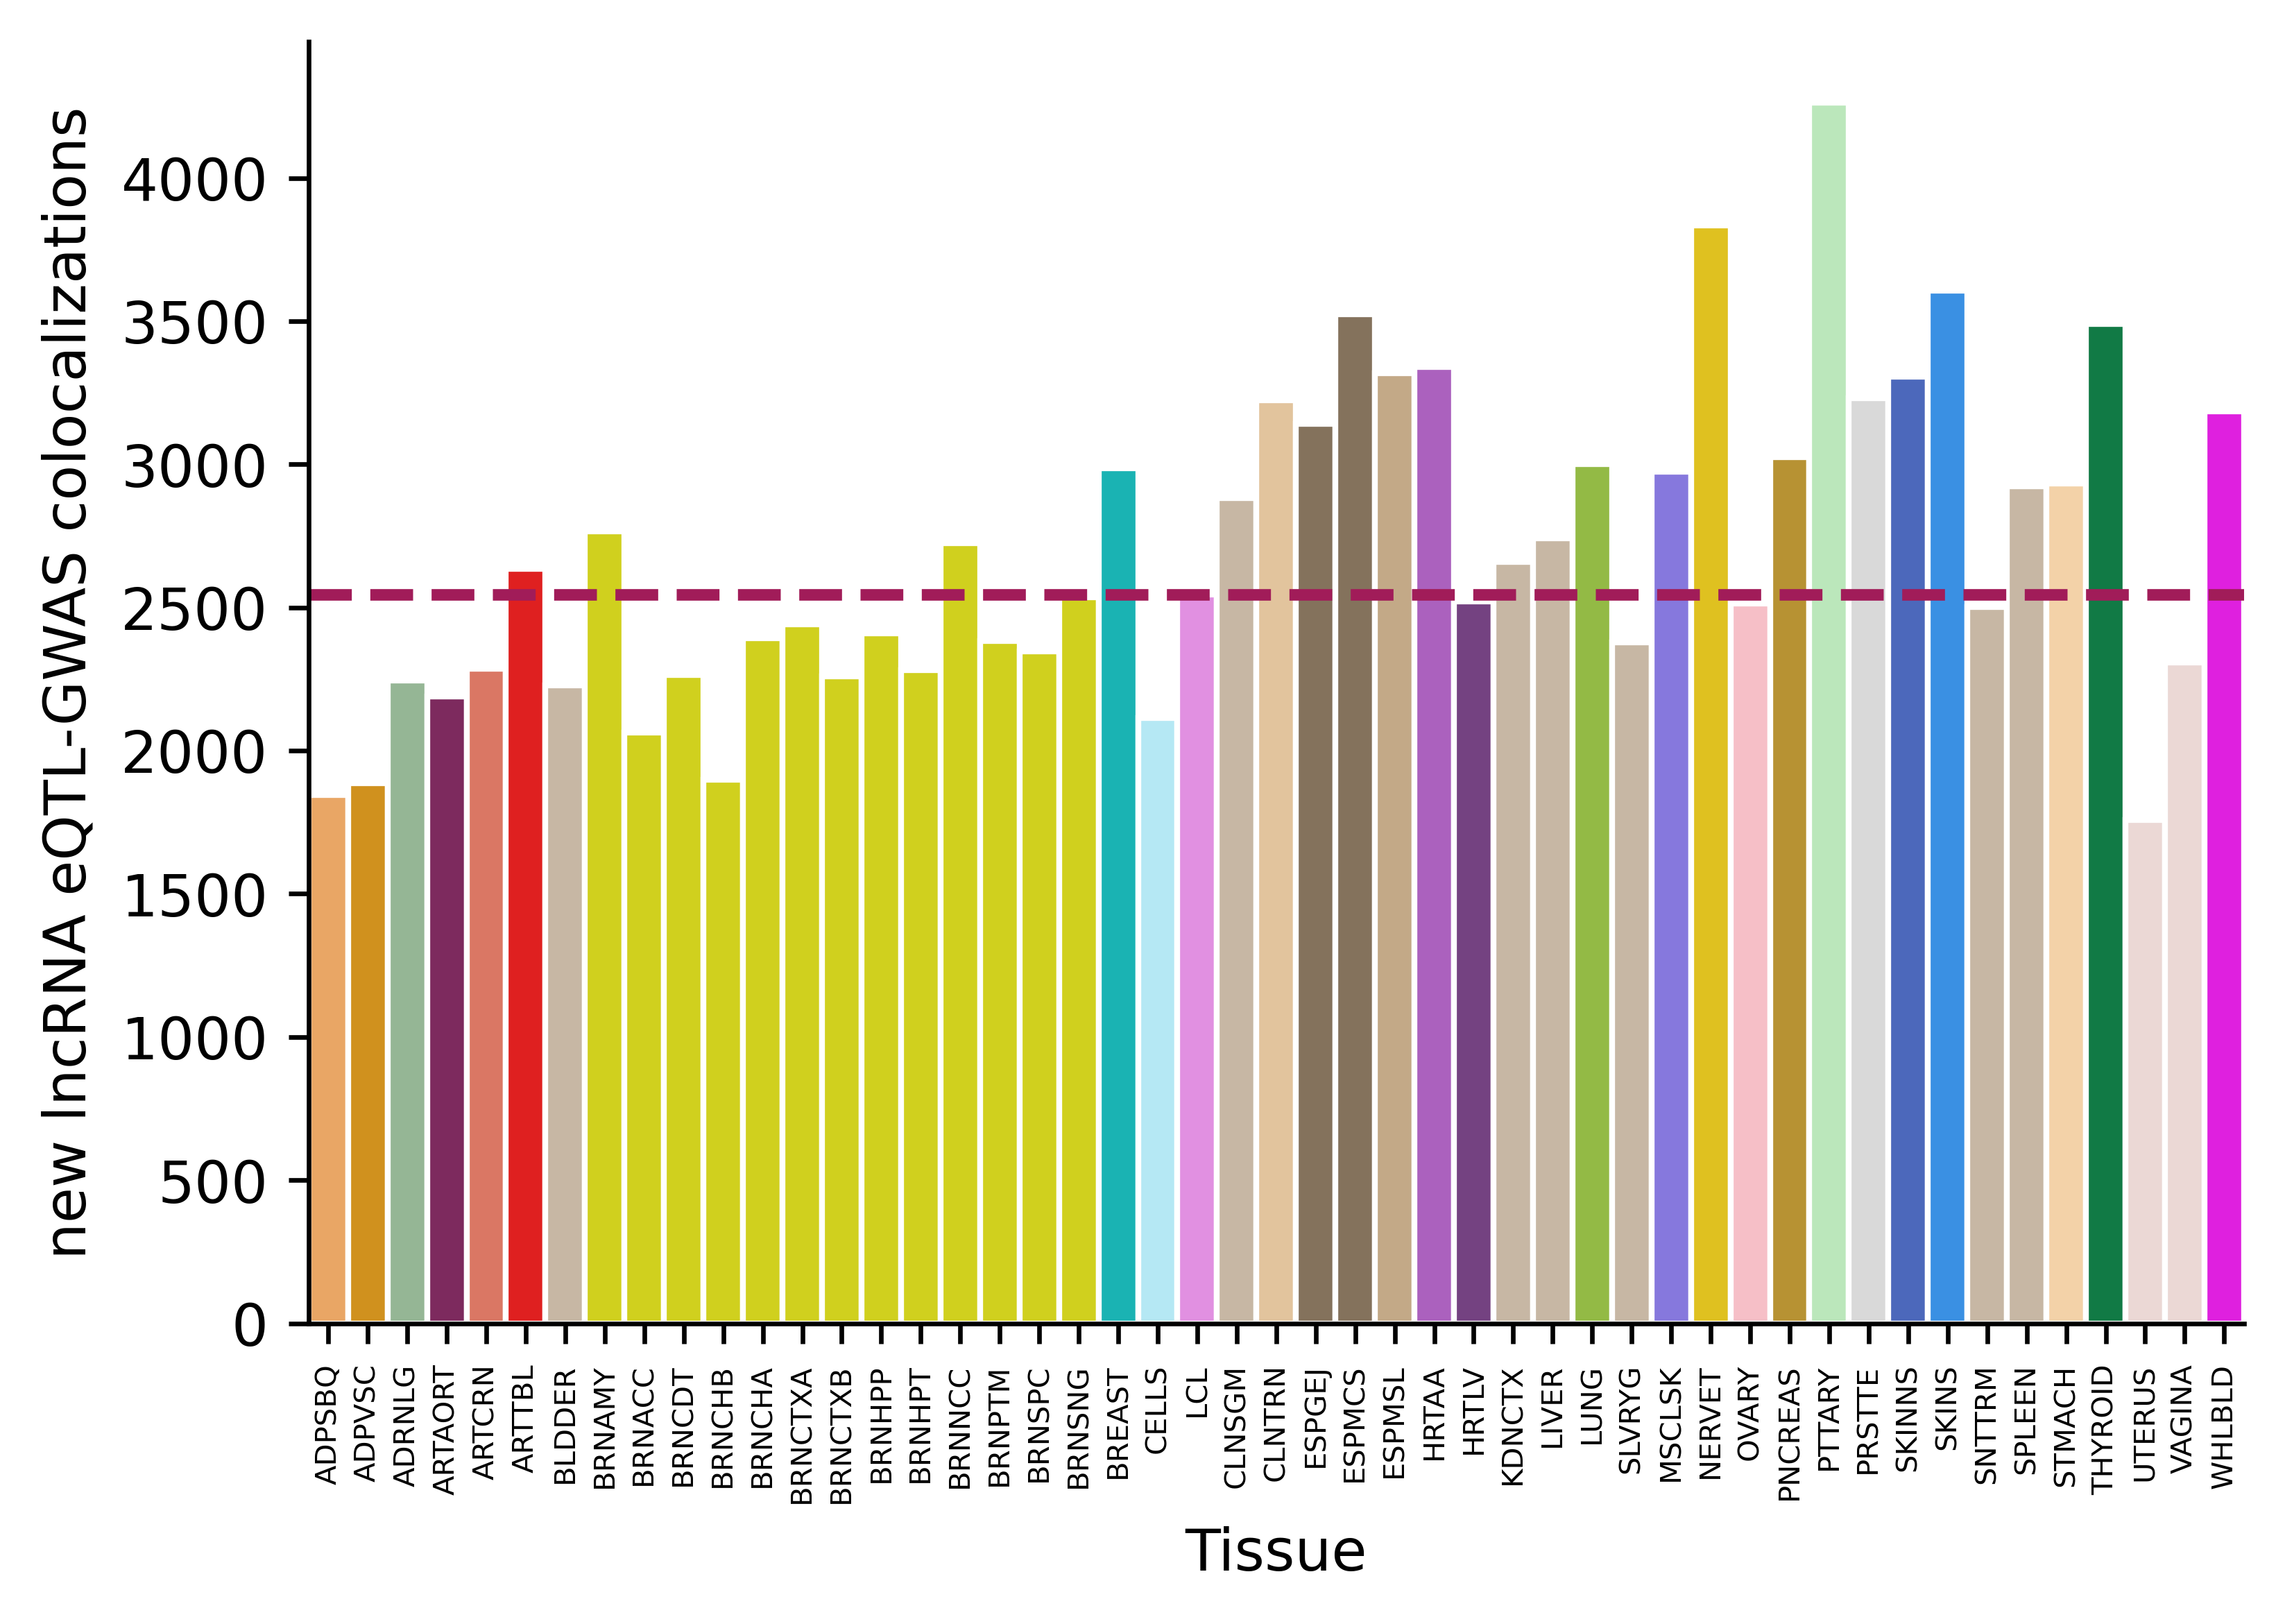

In [20]:
fig, ax = plt.subplots(1, figsize=(6, 4), dpi=600)
sns.set_style('whitegrid')

sns.barplot(strong_lncrna_colocs, x='tissue_file_name', y='count_any', hue='tissue_file_name', palette=tissue_color_map, ax=ax, legend=False, width=1)
print(strong_lncrna_colocs['count_any'].median())
ax.axhline(strong_lncrna_colocs['count_any'].median(), color='#a11c59', linestyle='--', linewidth=2)
#sns.barplot(strong_lncrna_colocs, x='tissue_file_name', y='count_specific', hue='tissue_file_name', palette=tissue_color_map, ax=ax, legend=False, edgecolor='black')
#sns.barplot(protien_shrared_colocs, x='tissue_file_name', y='count', ax=ax, legend=False, edgecolor='black', facecolor='none')

# set the x tick labels as the tissue abbreviations
abbrev_map = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_abbrv']))
tick_labels = [abbrev_map.get(t, t) for t in strong_lncrna_colocs['tissue_file_name']]
ax.set_xticklabels(tick_labels, fontsize=5, rotation=90)
sns.despine(ax=ax)
ax.set_ylabel('new lncRNA eQTL-GWAS colocalizations')
ax.set_xlabel('Tissue')
#ax.grid(axis='y', visible=True, linestyle='--', color='lightgray', linewidth=0.7)
ax.grid(axis='x', visible=False)

plt.show()

In [21]:
# Get the median number of protien_colding_shared == False colocs across tissues
print(len(new_lncrna_colocs) - new_lncrna_colocs['protien_colding_shared'].sum())

6361


percent of eqtLs with shared protein coding: 95.2%
medain not shared across tissues: 116.0
total number not shared: 6361


/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/65062824.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels, fontsize=5, rotation=90)


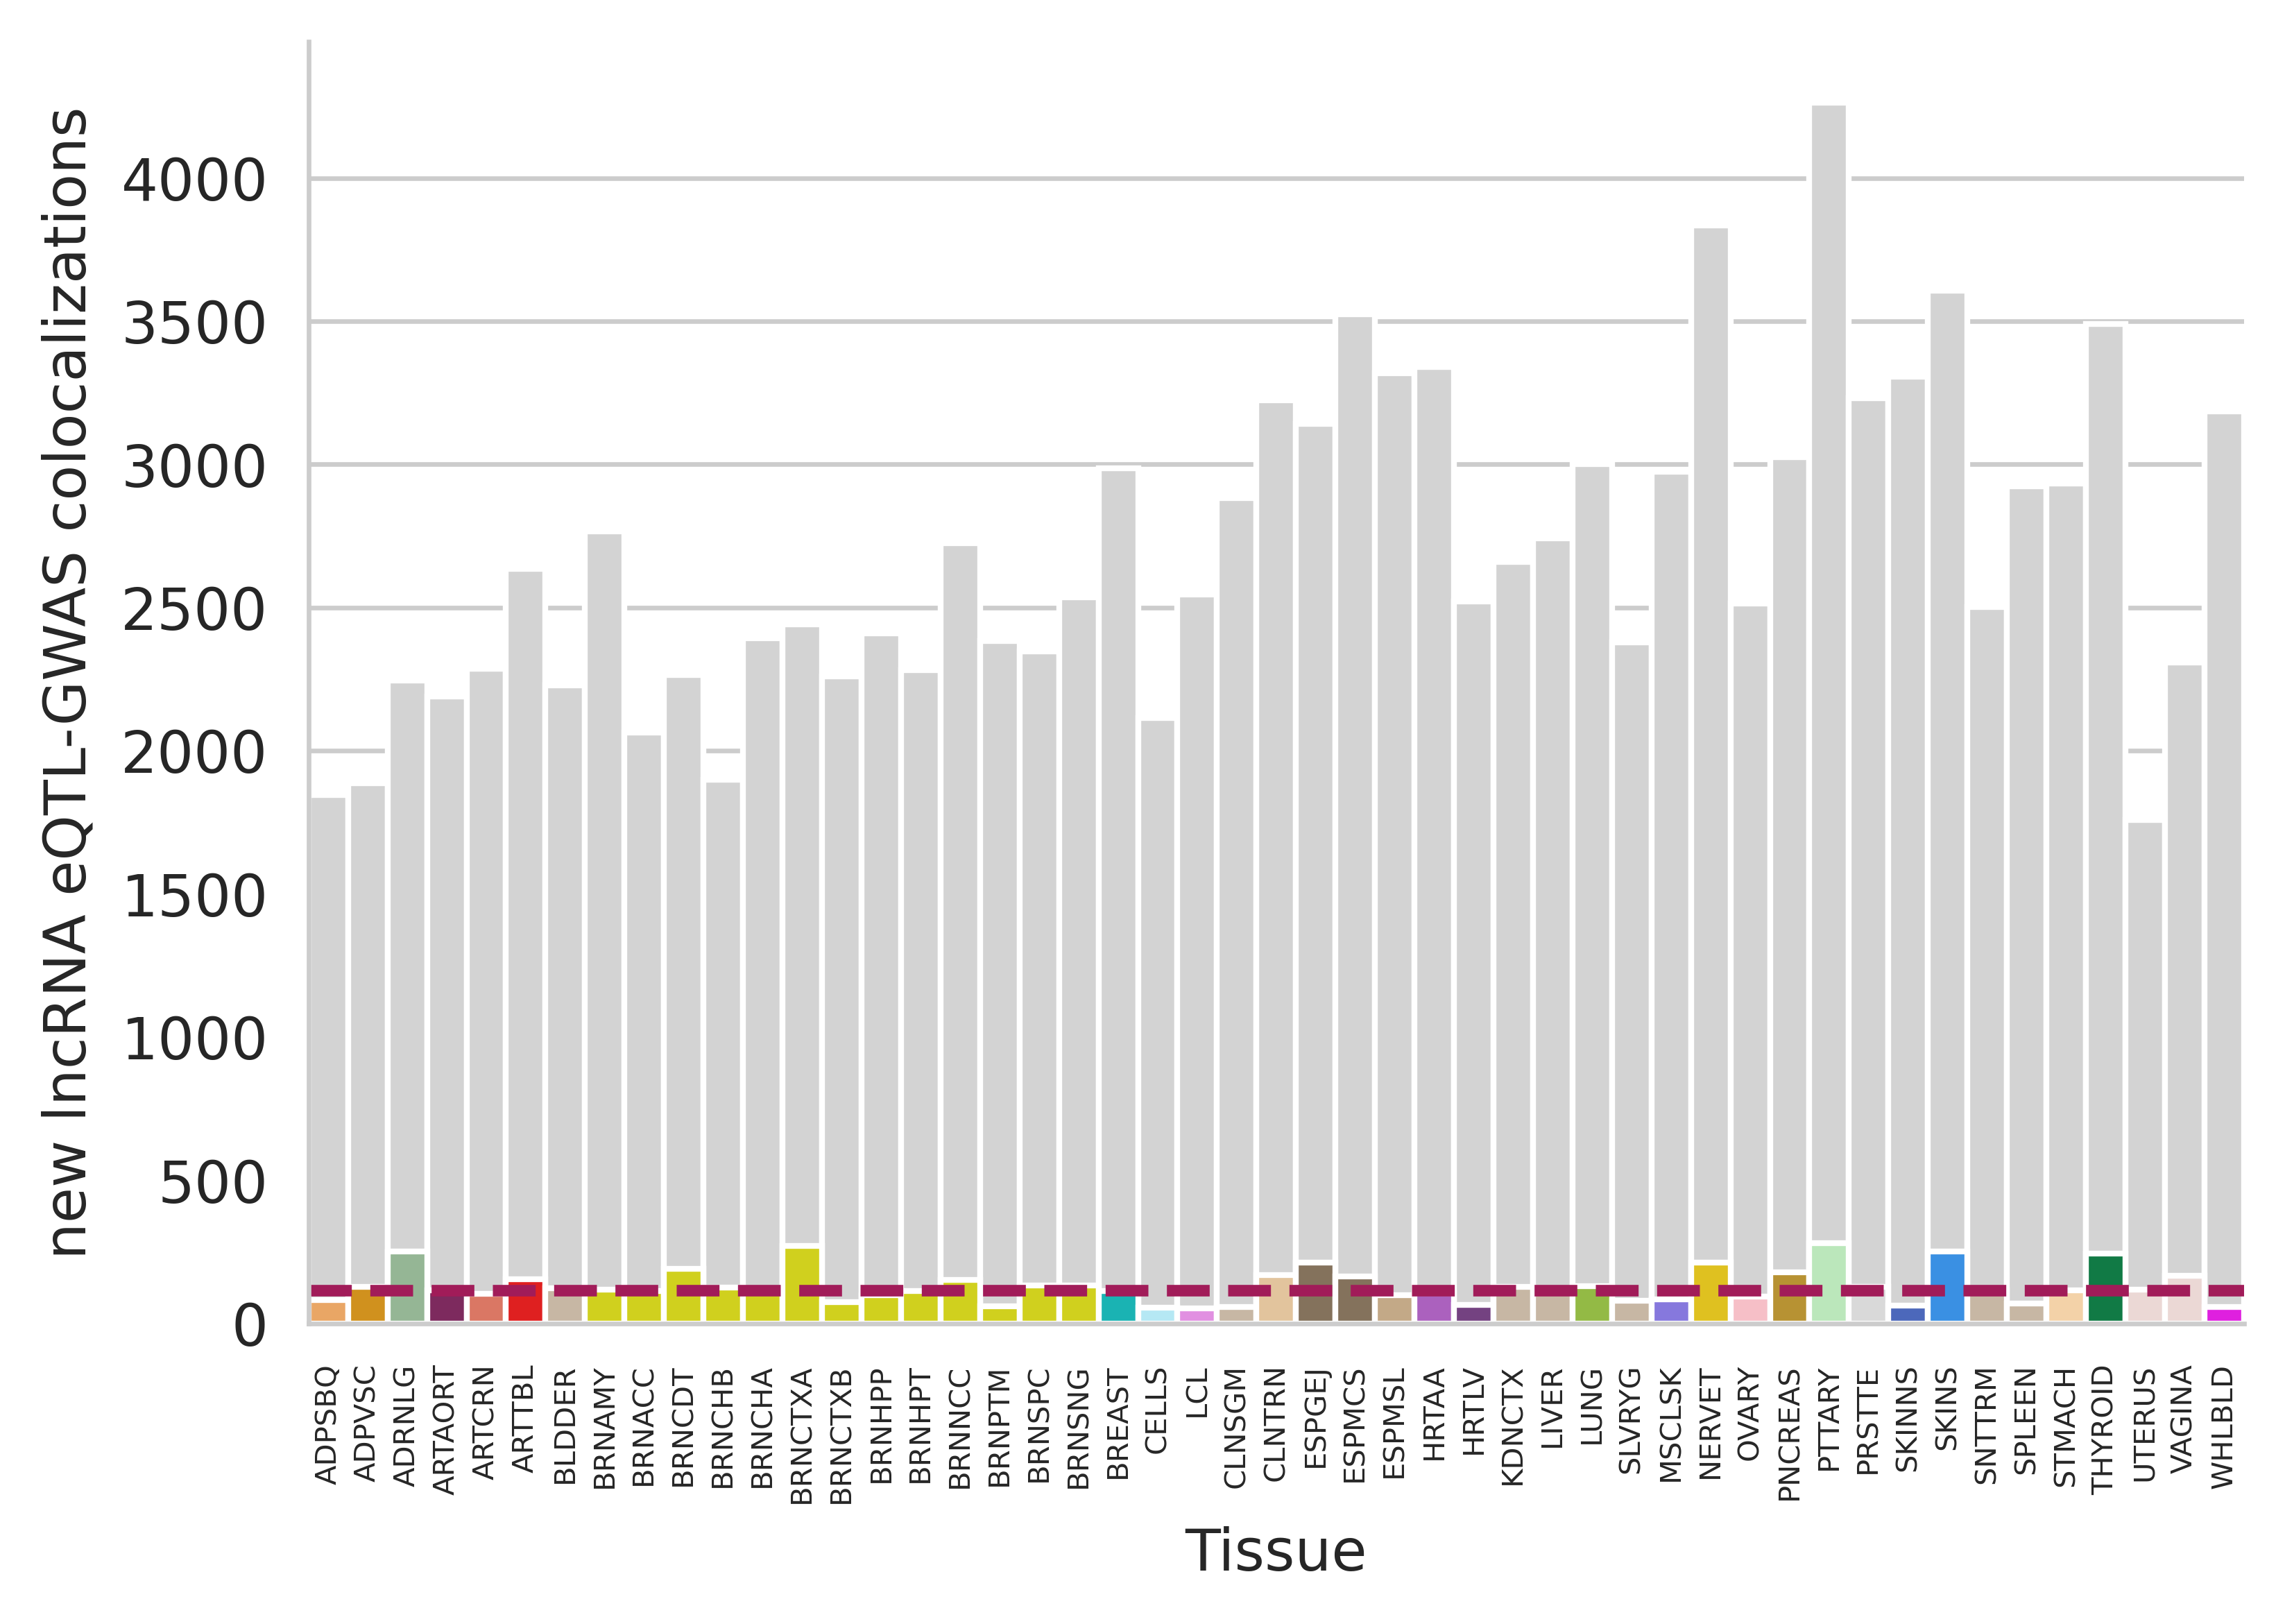

In [22]:
fig, ax = plt.subplots(1, figsize=(6, 4), dpi=600)
sns.set_style('whitegrid')

sns.countplot(new_lncrna_colocs, x='tissue_id', color='lightgrey', width=1)
sns.countplot(new_lncrna_colocs[~new_lncrna_colocs['protien_colding_shared']], x='tissue_id', hue='tissue_id', palette=tissue_color_map, ax=ax, legend=False, width=1)
num_not_shared = new_lncrna_colocs.groupby('tissue_id')['protien_colding_shared'].apply(lambda x: (~x).sum())
num_not_shared.median()
ax.axhline(num_not_shared.median(), color='#a11c59', linestyle='--', linewidth=2)
print('percent of eqtLs with shared protein coding: {:2.1f}%'.format(100*new_lncrna_colocs['protien_colding_shared'].mean()))
print('medain not shared across tissues: {}'.format(num_not_shared.median()))
print('total number not shared: {}'.format(num_not_shared.sum()))


abbrev_map = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_abbrv']))
tick_labels = [abbrev_map.get(t, t) for t in strong_lncrna_colocs['tissue_file_name']]
ax.set_xticklabels(tick_labels, fontsize=5, rotation=90)
sns.despine(ax=ax)
ax.set_ylabel('new lncRNA eQTL-GWAS colocalizations')
ax.set_xlabel('Tissue')
#ax.grid(axis='y', visible=True, linestyle='--', color='lightgray', linewidth=0.7)
ax.grid(axis='x', visible=False)

plt.show()

percent of eqtLs with shared protein coding: 98.7%
medain not shared across tissues: 31.0
total number not shared: 1781


/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/3512398564.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels, fontsize=5, rotation=90)


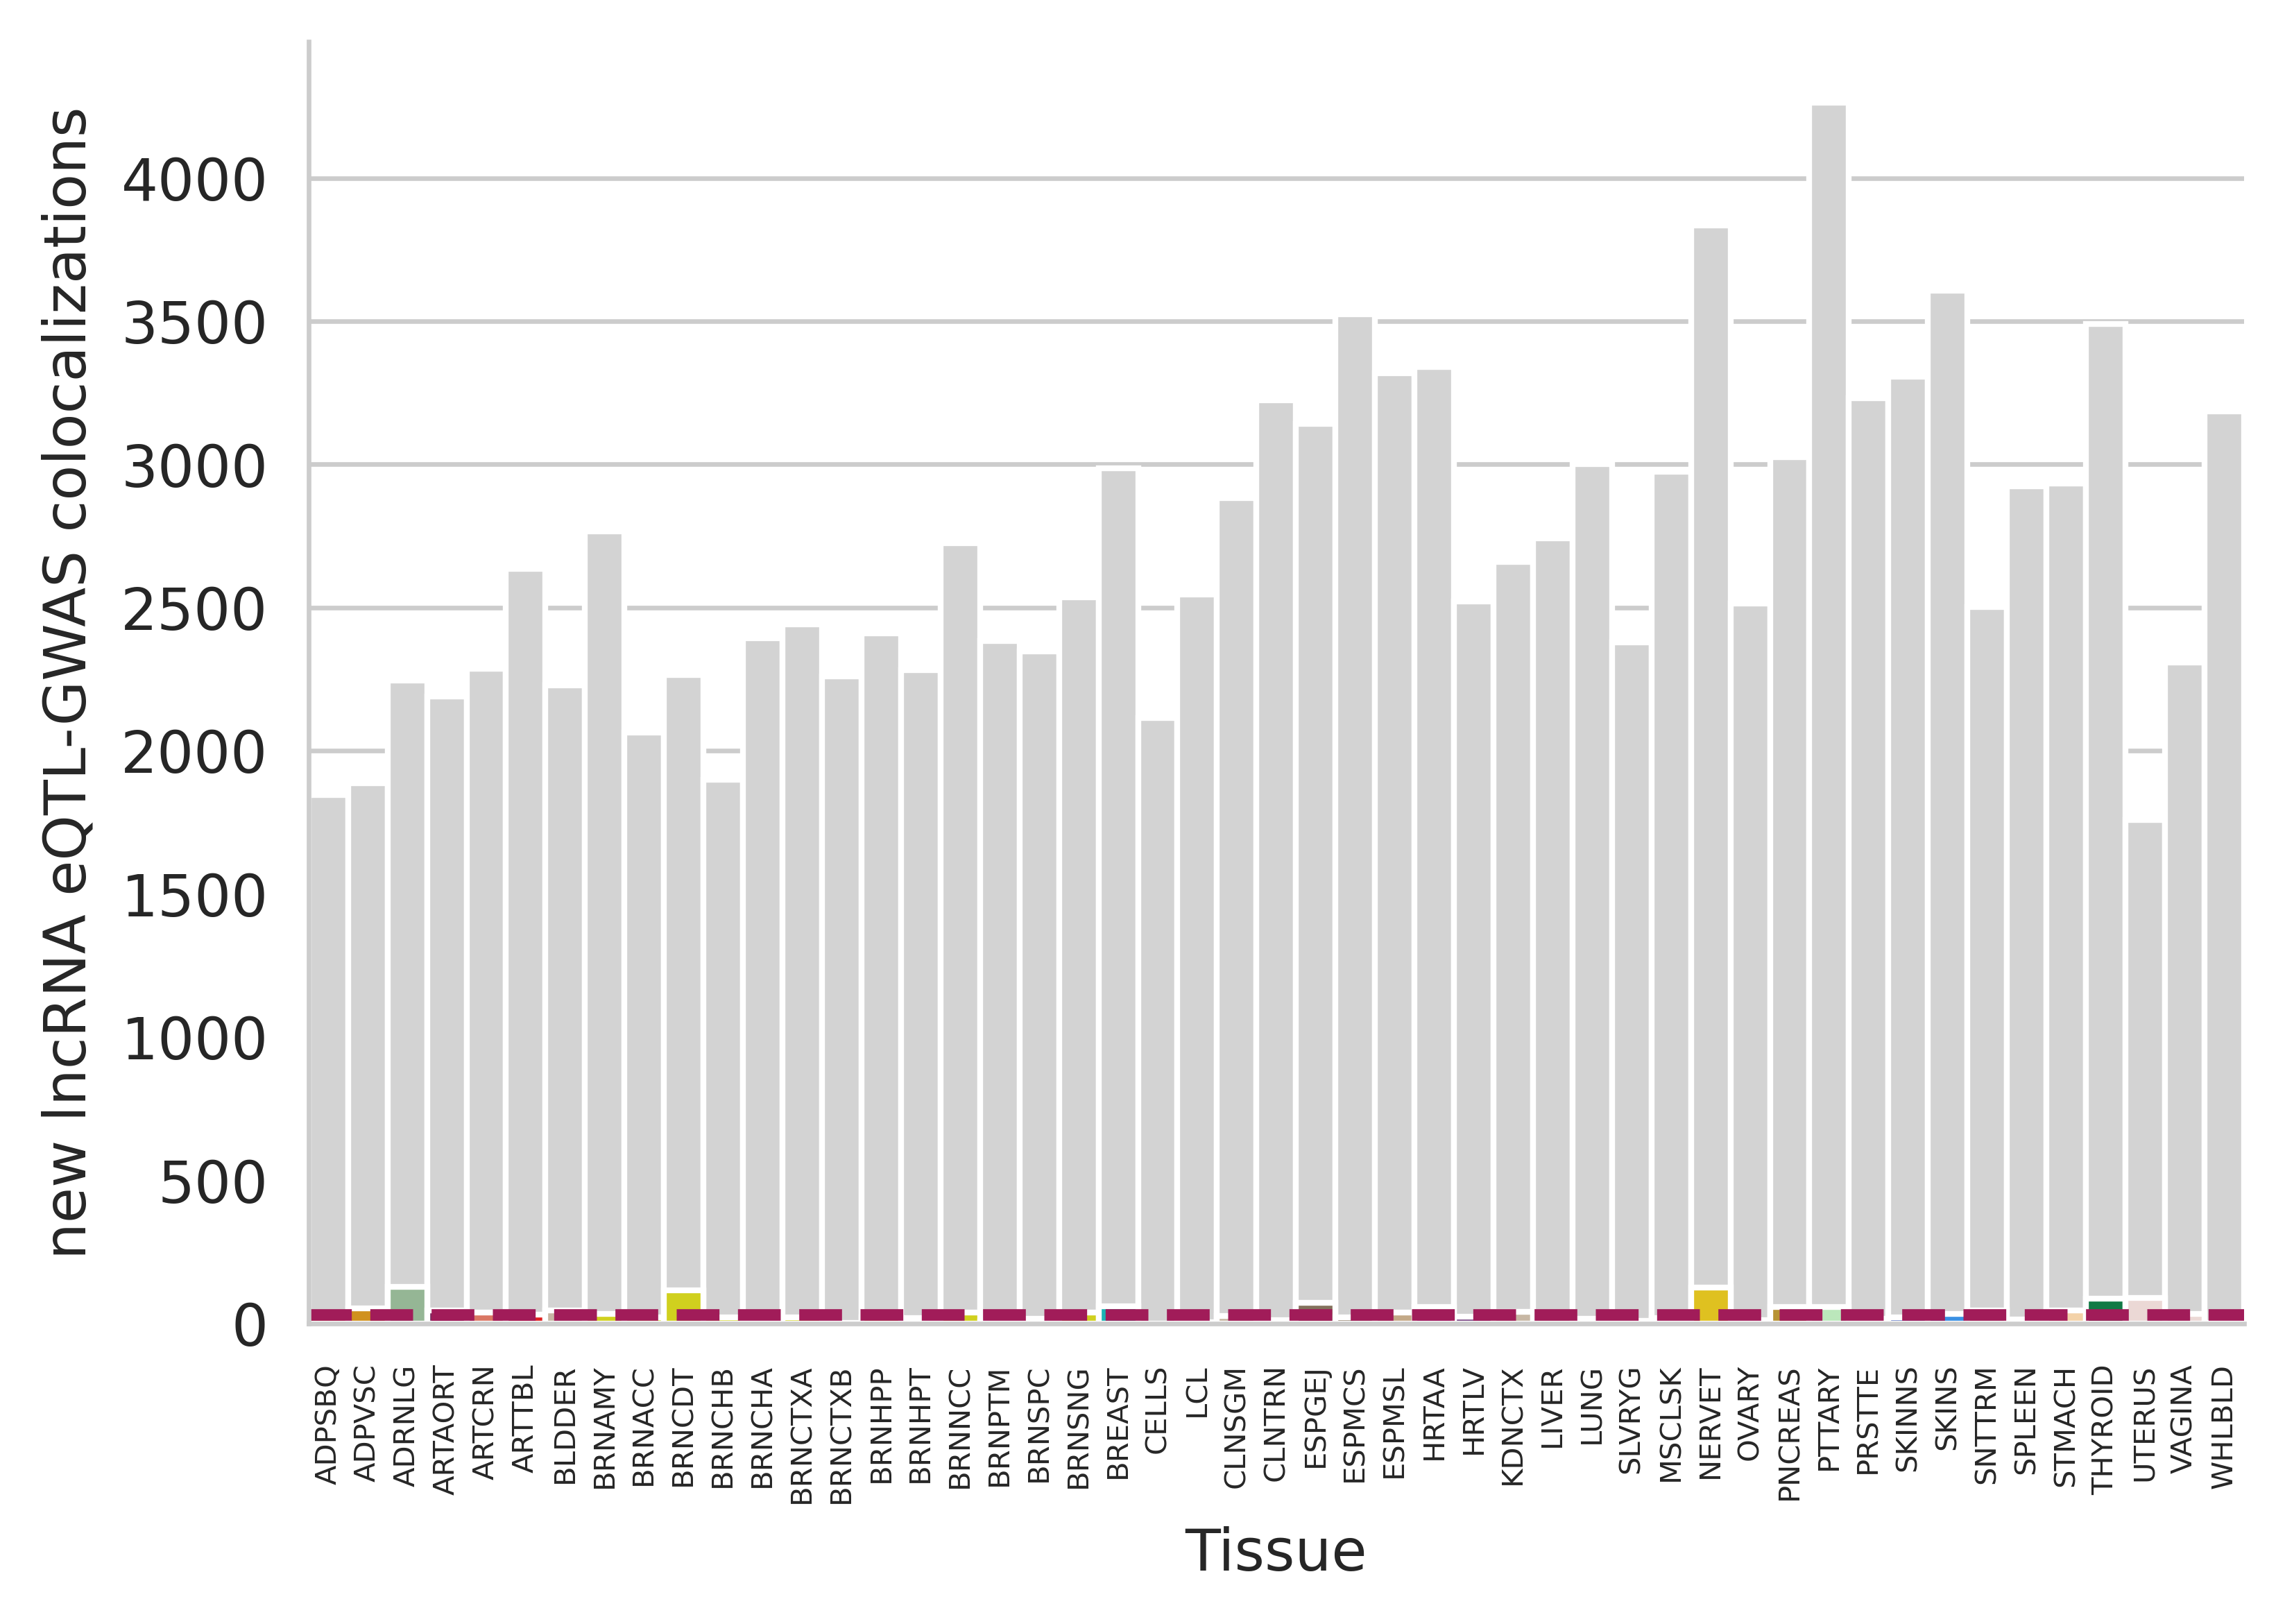

In [23]:
fig, ax = plt.subplots(1, figsize=(6, 4), dpi=600)
sns.set_style('whitegrid')

sns.countplot(new_lncrna_colocs, x='tissue_id', color='lightgrey', width=1, ax=ax)
sns.countplot(new_lncrna_colocs[~new_lncrna_colocs['any_shared']], x='tissue_id', hue='tissue_id', palette=tissue_color_map, ax=ax, legend=False, width=1)
num_not_shared = new_lncrna_colocs.groupby('tissue_id')['any_shared'].apply(lambda x: (~x).sum())
num_not_shared.median()
ax.axhline(num_not_shared.median(), color='#a11c59', linestyle='--', linewidth=2)
print('percent of eqtLs with shared protein coding: {:2.1f}%'.format(100*new_lncrna_colocs['any_shared'].mean()))
print('medain not shared across tissues: {}'.format(num_not_shared.median()))
print('total number not shared: {}'.format(num_not_shared.sum()))

abbrev_map = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_abbrv']))
tick_labels = [abbrev_map.get(t, t) for t in strong_lncrna_colocs['tissue_file_name']]
ax.set_xticklabels(tick_labels, fontsize=5, rotation=90)
sns.despine(ax=ax)
ax.set_ylabel('new lncRNA eQTL-GWAS colocalizations')
ax.set_xlabel('Tissue')
#ax.grid(axis='y', visible=True, linestyle='--', color='lightgray', linewidth=0.7)
ax.grid(axis='x', visible=False)

plt.show()

In [24]:
# how many discovered by single gene anlysis?
egene_results_dir = "/home/klawren/oak/gtex/output/qtl/GTEx_Analysis_v11_eQTL"

# load in the eSusie files
esusie = []
esusie_tissues = []
for id, row in qtl_tissue_df.iterrows():
    try:
        esusie.append(pd.read_parquet(f"{egene_results_dir}/{row['tissue_file_name']}.v11.eQTLs.SuSiE_summary.parquet"))
        esusie_tissues.append(row['tissue_file_name'])
    except:
        print(f"No eSusie results for {row['tissue_file_name']}")
esusie_df = pd.concat(esusie, keys=esusie_tissues, names=['tissue_id', 'idx']).reset_index(level=1, drop=True).reset_index()
esusie_df['variant_id_peco'] = esusie_df['variant_id'].str.replace('_', ':')

In [25]:
new_lncrna_colocs_explode = new_lncrna_colocs.explode('individual_phenotype_id')
new_lncrna_gene_explode = new_lncrna_colocs_explode[new_lncrna_colocs_explode['individual_phenotype_id'].str.contains('ENSG')]
new_lncrna_gene_explode['gene_id'] =new_lncrna_gene_explode['individual_phenotype_id'].str.split('.').str[1:3].str.join('.')

# annoate those that have the same phenotype-variant in eSUSIE
lncrna_keys = list(zip(new_lncrna_gene_explode['variant_id'], new_lncrna_gene_explode['gene_id']))
esusie_keys = set(zip(esusie_df['variant_id_peco'], esusie_df['phenotype_id']))
new_lncrna_gene_explode['in_esusie'] = [key in esusie_keys for key in lncrna_keys]

single_gene_overlap = new_lncrna_gene_explode[new_lncrna_gene_explode['in_esusie']]
single_gene_overlap = pd.merge(single_gene_overlap, gencode_ids[['gene_id_v47', 'gene_type_grouped_highlight']], left_on='gene_id', right_on='gene_id_v47', how='left')

single_gene_overlap_grouped = single_gene_overlap.groupby('unique_cos_id').agg({'gene_id':'unique', 'gene_type_grouped_highlight':'unique'}).reset_index()
single_gene_overlap_grouped.rename(columns={'gene_id':'gene_ids_single', 'gene_type_grouped_highlight':'gene_types_single'}, inplace=True)
single_gene_overlap_grouped['in_single_gene'] = True
single_gene_overlap_grouped.head()

/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/1046581651.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_lncrna_gene_explode['gene_id'] =new_lncrna_gene_explode['individual_phenotype_id'].str.split('.').str[1:3].str.join('.')
/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/1046581651.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_lncrna_gene_explode['in_esusie'] = [key in esusie_keys for key in lncrna_keys]


,unique_cos_id,gene_ids_single,gene_types_single,in_single_gene
0,"Adipose_Subcutaneous.ENSG00000002726.21,GIANT_...","[ENSG00000002726.21, ENSG00000309641.1]","[protein_coding, new_lncRNA]",True
1,"Adipose_Subcutaneous.ENSG00000009830.13,Astle_...",[ENSG00000009830.13],[protein_coding],True
2,"Adipose_Subcutaneous.ENSG00000013583.10,UKB_50...","[ENSG00000100577.19, ENSG00000253669.5]","[protein_coding, existing_lncRNA]",True
3,"Adipose_Subcutaneous.ENSG00000026297.17,Adipos...","[ENSG00000026297.17, ENSG00000213066.14, ENSG0...","[protein_coding, new_lncRNA]",True
4,"Adipose_Subcutaneous.ENSG00000048471.14,Adipos...","[ENSG00000048471.14, ENSG00000259876.1, ENSG00...","[protein_coding, existing_lncRNA, new_lncRNA]",True


In [26]:
# merge back in to the new_lncrna_specific_colocs
new_lncrna_colocs_annotated = pd.merge(new_lncrna_colocs, single_gene_overlap_grouped, left_on='unique_cos_id', right_on='unique_cos_id', how='left')
new_lncrna_colocs_annotated['in_single_gene'].fillna(False, inplace=True)
print('signle gene catches {:2.1f}% of new lncRNA specific colocs'.format(100*new_lncrna_colocs_annotated['in_single_gene'].mean()))

def na_safe_lncrna_specific(x):
    try:
        return all(gene_type == 'new_lncRNA' for gene_type in x)
    except:
        return 'no_gene'

def na_safe_protein_shared(x):
    try:
        return any(gene_type == 'protein_coding' for gene_type in x)
    except:
        return 'no_gene'

new_lncrna_colocs_annotated['single_gene_new_lncrna_specific'] = new_lncrna_colocs_annotated['gene_types_single'].apply(na_safe_lncrna_specific)
new_lncrna_colocs_annotated['single_gene_protein_shared'] = new_lncrna_colocs_annotated['gene_types_single'].apply(na_safe_protein_shared)
new_lncrna_colocs_annotated[['new_lncrna_specific', 'single_gene_new_lncrna_specific', 'single_gene_protein_shared']].value_counts()


/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/1568635691.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_lncrna_colocs_annotated['in_single_gene'].fillna(False, inplace=True)
/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/1568635691.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  

signle gene catches 98.4% of new lncRNA specific colocs


new_lncrna_specific  single_gene_new_lncrna_specific  single_gene_protein_shared
False                False                            True                          124203
                                                      False                           3556
                     True                             False                           1388
                     no_gene                          no_gene                         1379
True                 no_gene                          no_gene                          780
                     True                             False                            507
                     False                            True                             349
                                                      False                            145
Name: count, dtype: int64

median not shared: 31.0
total not shared: 1781
(np.float64(0.0), np.float64(133.35))


/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/3746705875.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels, fontsize=5, rotation=90)


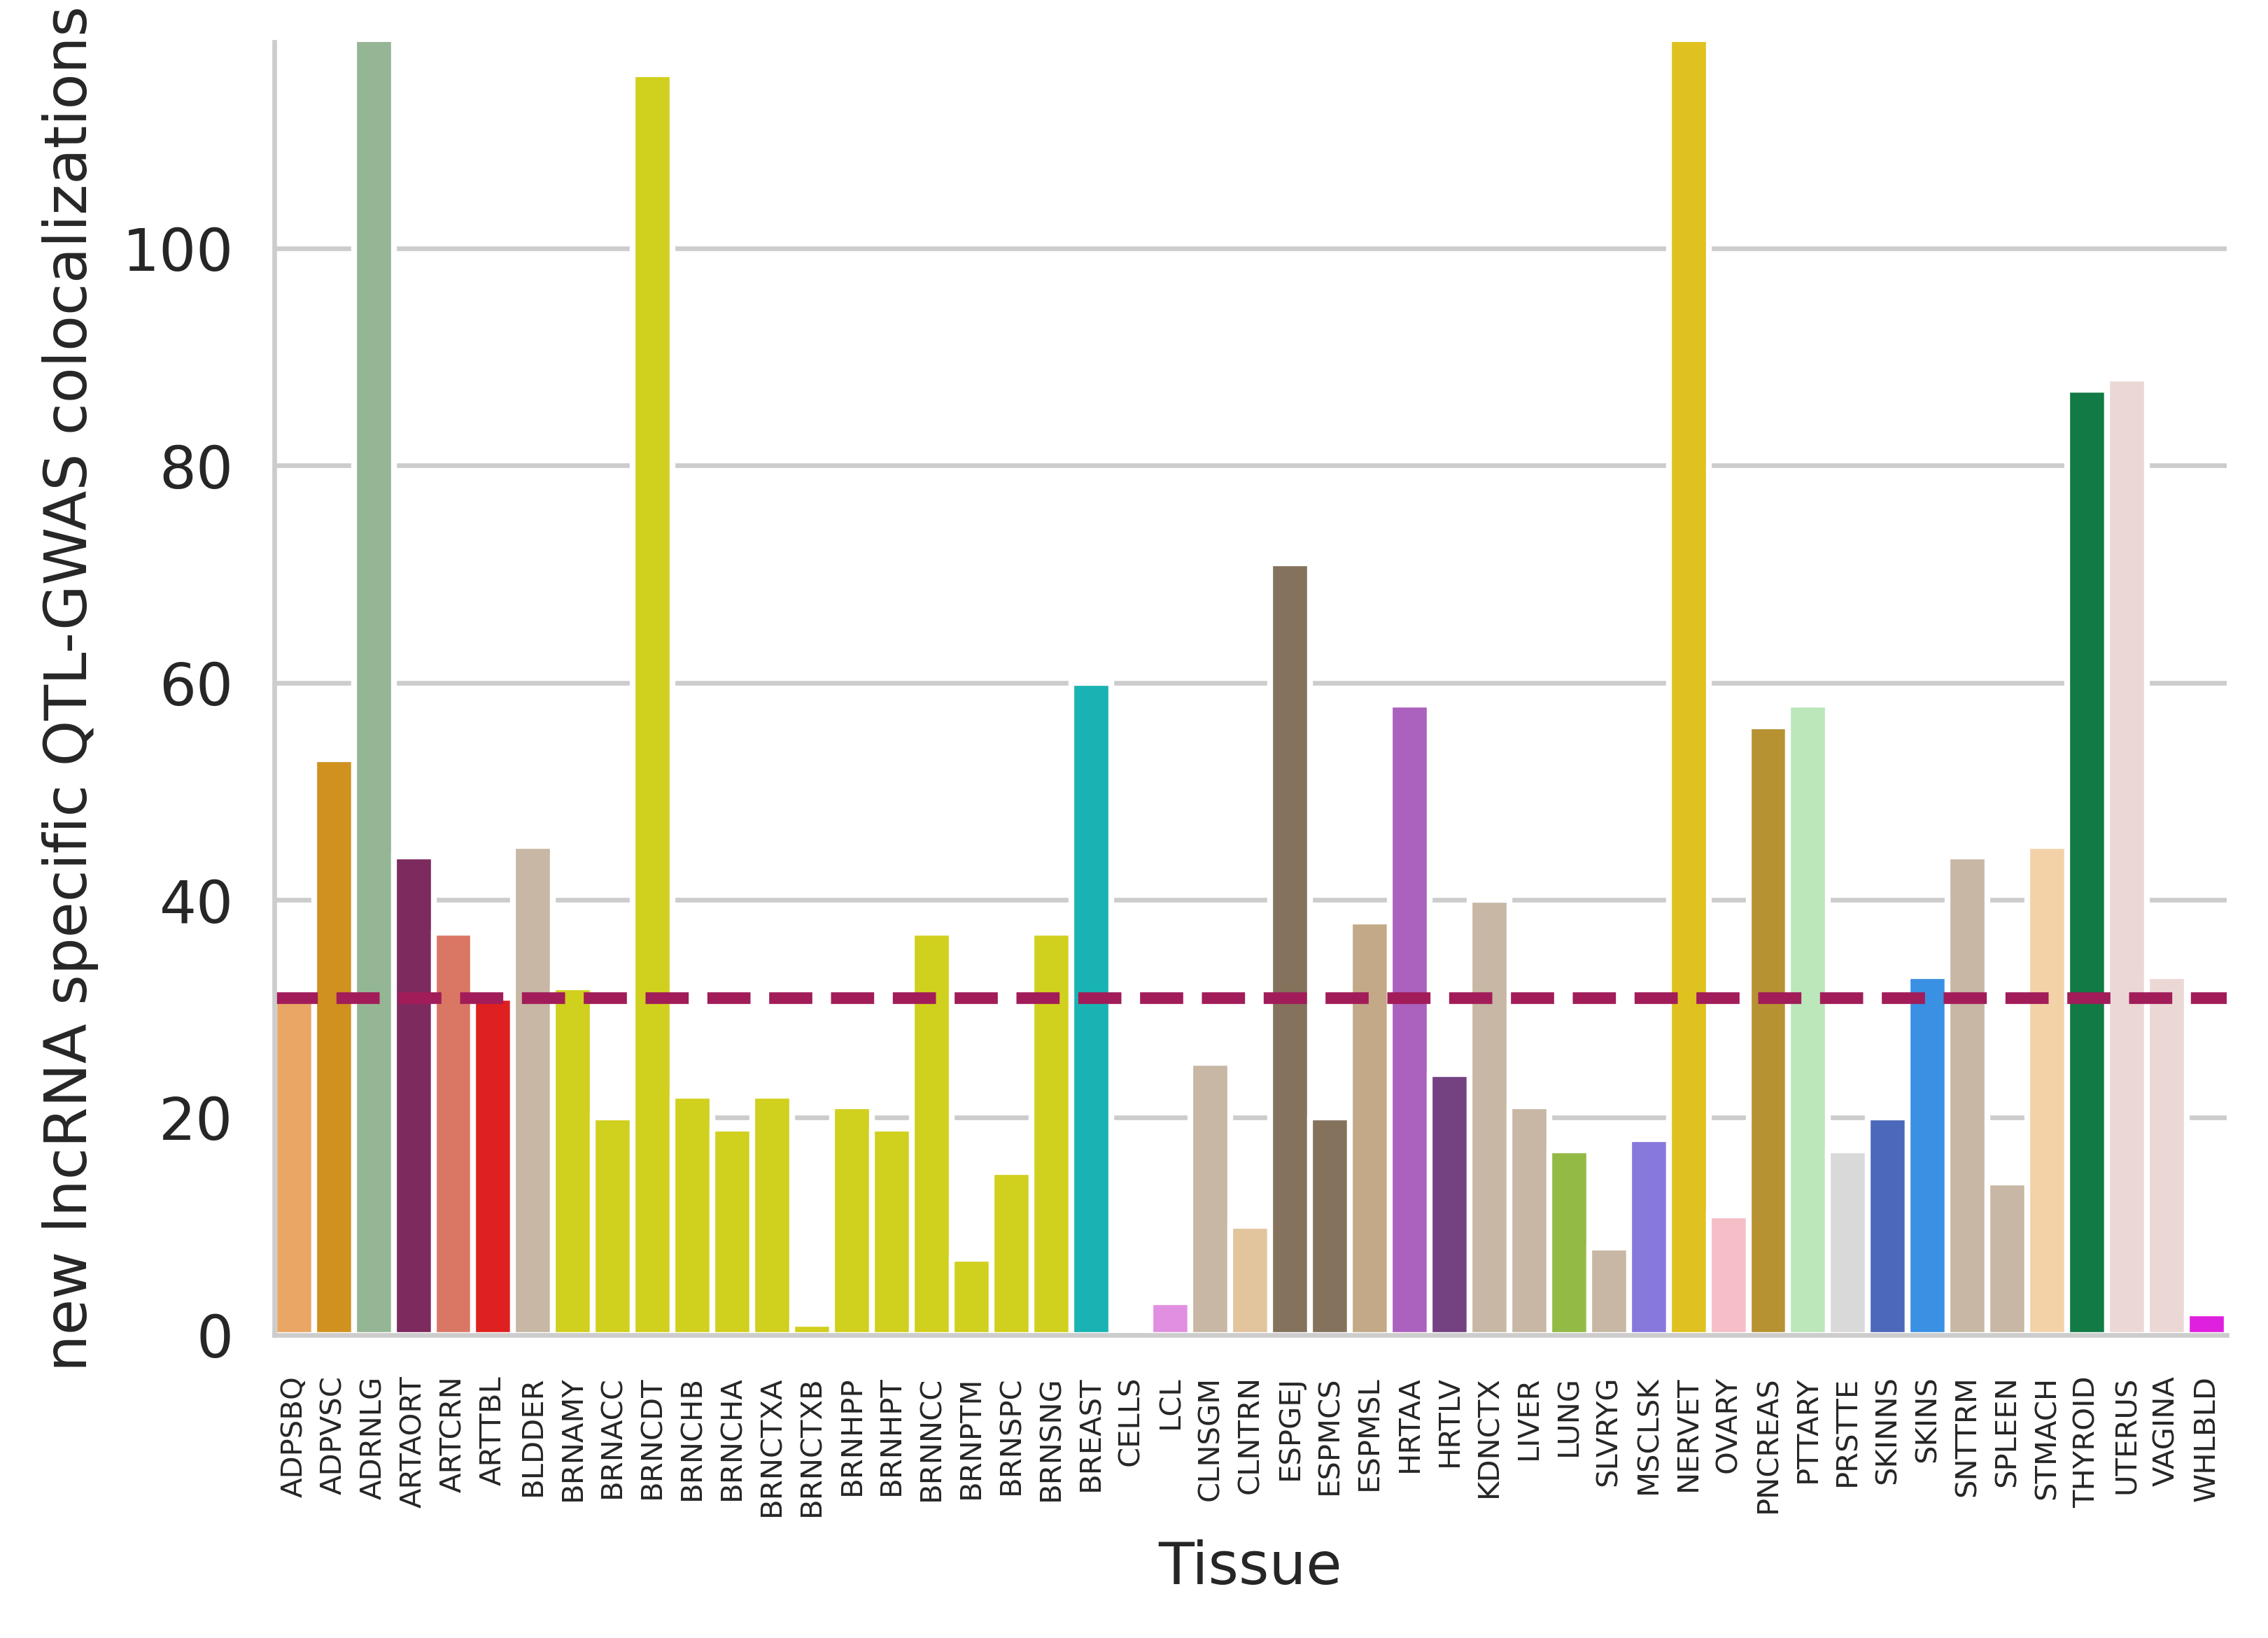

In [27]:
fig, ax = plt.subplots(1, figsize=(6, 4), dpi=600)
sns.set_style('whitegrid')

#sns.countplot(new_lncrna_colocs[new_lncrna_colocs['any_shared']], x='tissue_id', color='lightgrey')
#sns.countplot(new_lncrna_colocs_annotated[new_lncrna_colocs_annotated['single_gene_new_lncrna_specific']!=False], x='tissue_id', color='darkgrey', width=1, ax=ax)
new_lncrna_specific_counts = pd.merge(new_lncrna_colocs[new_lncrna_colocs['new_lncrna_specific']].groupby('tissue_id').size().reset_index(name='new_lncrna_specific'), qtl_tissue_df, left_on='tissue_id', right_on='tissue_file_name', how='right')
sns.barplot(new_lncrna_specific_counts, x='tissue_file_name', y='new_lncrna_specific', hue='tissue_file_name', palette=tissue_color_map, ax=ax, legend=False, width=1)

num_not_shared_multi = new_lncrna_colocs.groupby('tissue_id')['new_lncrna_specific'].sum()
median_not_shared_multi = num_not_shared_multi.median()

# Add hlines for medians of both groups
#ax.axhline(median_not_shared_single, color='k', linestyle='--', linewidth=2, label='Median Not Shared Single')
ax.axhline(median_not_shared_multi, color='#a11c59', linestyle='--', linewidth=2, label='Median Not Shared Multi')

print('median not shared: {}'.format(median_not_shared_multi))
print('total not shared: {}'.format(num_not_shared_multi.sum()))

abbrev_map = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_abbrv']))
tick_labels = [abbrev_map.get(t, t) for t in strong_lncrna_colocs['tissue_file_name']]
ax.set_xticklabels(tick_labels, fontsize=5, rotation=90)
sns.despine(ax=ax)
ax.set_ylabel('new lncRNA specific QTL-GWAS colocalizations')
ax.set_xlabel('Tissue')
#ax.grid(axis='y', visible=True, linestyle='--', color='lightgray', linewidth=0.7)
ax.grid(axis='x', visible=False)
print(ax.get_ylim())
ax.set_ylim(0, 119)
ax.set_xlim(np.float64(-0.5), np.float64(48.5))
plt.show()

percent of eqtLs with shared protein coding: 95.2%
median not shared single: 74.0
median not shared multi: 31.0
percent overestimation with single gene: 127.6%
(np.float64(0.0), np.float64(189.0))
(np.float64(-0.5), np.float64(48.5))


/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/240916916.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels, fontsize=5, rotation=90)


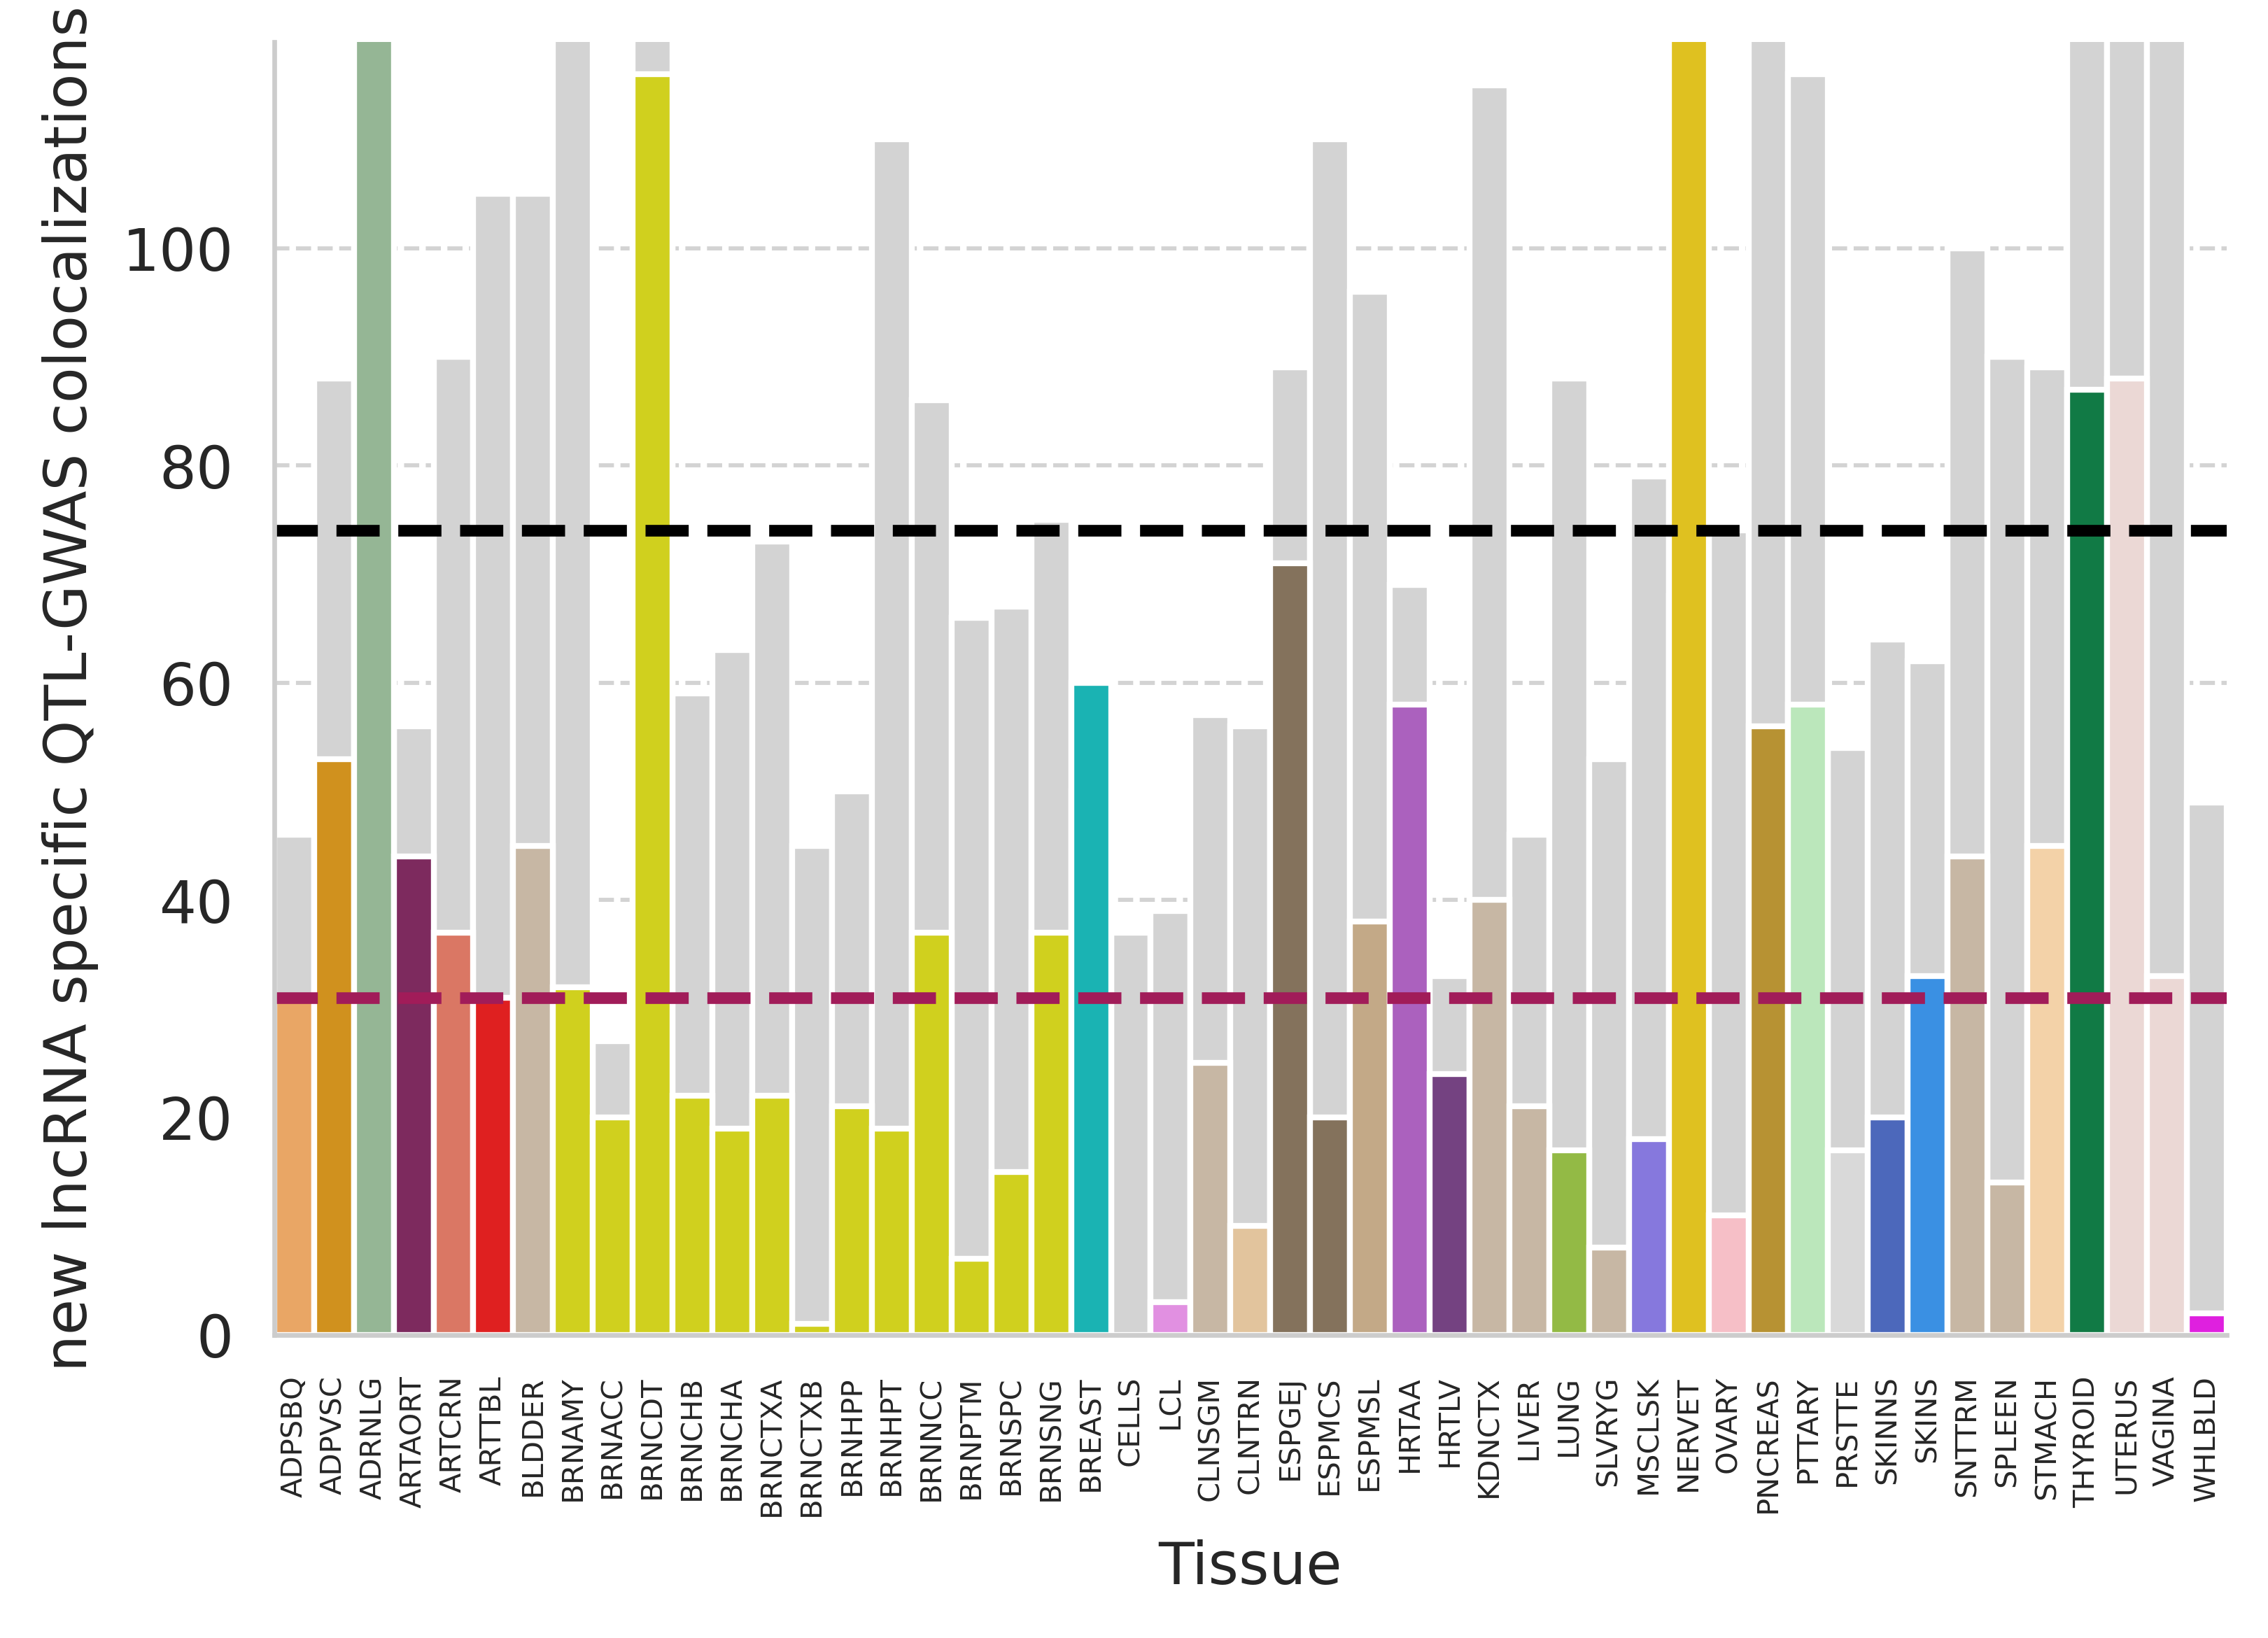

In [28]:
fig, ax = plt.subplots(1, figsize=(6, 4), dpi=600)
sns.set_style('whitegrid')

#sns.countplot(new_lncrna_colocs[new_lncrna_colocs['any_shared']], x='tissue_id', color='lightgrey')
sns.countplot(new_lncrna_colocs_annotated[new_lncrna_colocs_annotated['single_gene_new_lncrna_specific']!=False], x='tissue_id', color='lightgrey', width=1, ax=ax)
sns.countplot(new_lncrna_colocs[new_lncrna_colocs['new_lncrna_specific']], x='tissue_id', hue='tissue_id', palette=tissue_color_map, ax=ax, legend=False, width=1)

# Compute number of not shared and shared protein_coding colocs per tissue
num_not_shared_single = new_lncrna_colocs_annotated.groupby('tissue_id')['single_gene_new_lncrna_specific'].apply(lambda x: (x!=False).sum())
num_not_shared_multi = new_lncrna_colocs.groupby('tissue_id')['new_lncrna_specific'].sum()

# Calculate medians
median_not_shared_single = num_not_shared_single.median()
median_not_shared_multi = num_not_shared_multi.median()

# Add hlines for medians of both groups
ax.axhline(median_not_shared_single, color='k', linestyle='--', linewidth=2, label='Median Not Shared Single')
ax.axhline(median_not_shared_multi, color='#a11c59', linestyle='--', linewidth=2, label='Median Not Shared Multi')

print('percent of eqtLs with shared protein coding: {:2.1f}%'.format(100*new_lncrna_colocs['protien_colding_shared'].mean()))
print('median not shared single: {}'.format(median_not_shared_single))
print('median not shared multi: {}'.format(median_not_shared_multi))
print('percent overestimation with single gene: {:2.1f}%'.format((num_not_shared_single.sum()-num_not_shared_multi.sum())/num_not_shared_multi.sum()*100))

abbrev_map = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_abbrv']))
tick_labels = [abbrev_map.get(t, t) for t in strong_lncrna_colocs['tissue_file_name']]
ax.set_xticklabels(tick_labels, fontsize=5, rotation=90)
sns.despine(ax=ax)
ax.set_ylabel('new lncRNA specific QTL-GWAS colocalizations')
ax.set_xlabel('Tissue')
ax.grid(axis='y', visible=True, linestyle='--', color='lightgray', linewidth=0.7)
ax.grid(axis='x', visible=False)
print(ax.get_ylim())
ax.set_ylim(0, 119)
print(ax.get_xlim())
plt.show()

the ones unique to new lncRNAs (also look for unique across all tissues)

In [29]:
new_lncrna_specific_colocs['unique_cos_id'].unique()

array(['Adipose_Subcutaneous.ENSG00000301029.1,Astle_et_al_2016_Platelet_count-:-cos2:y15_y38-:-Adipose_Subcutaneous-:-chr13:108810279-110581699-:-trait_shared-:-all_genes',
       'Adipose_Subcutaneous.ENSG00000301360.1,UKB_50_Standing_height-:-cos1:y50_y55-:-Adipose_Subcutaneous-:-chr3:45779016-47151274-:-trait_shared-:-all_genes',
       'Adipose_Subcutaneous.ENSG00000290851.2,UKB_50_Standing_height-:-cos1:y44_y61-:-Adipose_Subcutaneous-:-chr1:15663424-17857084-:-trait_shared-:-all_genes',
       'Adipose_Subcutaneous.ENSG00000309570.1,GIANT_2017_BMI_Active_EUR-:-cos4:y19_y40-:-Adipose_Subcutaneous-:-chr2:24172401-25925747-:-trait_shared-:-all_genes',
       'Adipose_Subcutaneous.ENSG00000293664.1,Astle_et_al_2016_Reticulocyte_count-:-cos1:y10_y24-:-Adipose_Subcutaneous-:-chr8:40678174-41866032-:-trait_shared-:-all_genes',
       'Adipose_Subcutaneous.ENSG00000293488.2,Astle_et_al_2016_Lymphocyte_counts-:-cos7:y53_y78-:-Adipose_Subcutaneous-:-chr12:8604886-9849404-:-trait_shared-:-a

In [30]:
# check if any of the cs variants are associated iwth other gene types in other tissues

lncrna_specific_vars = all_coloc_robust_dfs[all_coloc_robust_dfs['variant_id'].isin(new_lncrna_specific_colocs['variant_id'])]

lncrna_specific_vars_explode =  lncrna_specific_vars.explode(['individual_phenotype_id'])
lncrna_specific_vars_explode = lncrna_specific_vars_explode[lncrna_specific_vars_explode['individual_phenotype_id'].str.contains('ENSG')]
lncrna_specific_vars_explode['gene_id'] = lncrna_specific_vars_explode['individual_phenotype_id'].str.split('.').str[1]
lncrna_specific_vars_explode = pd.merge(lncrna_specific_vars_explode, gencode_ids, left_on='gene_id', right_on='gene_id_stable', how='left')
lncrna_specific_vars_explode['gene_type_grouped_highlight'].value_counts()
other_gene_type_vars = lncrna_specific_vars_explode[lncrna_specific_vars_explode['gene_type_grouped_highlight']!= 'new_lncRNA']['variant_id'].unique()


new_lncrna_specific_colocs['other_tissue_other_gene_type_coloc'] = new_lncrna_specific_colocs['variant_id'].isin(other_gene_type_vars)
other_tissue_other_gene_type_colocs = new_lncrna_specific_colocs.groupby('unique_cos_id').agg({'other_tissue_other_gene_type_coloc': any}).reset_index()

/local/scratch/klawren/slrmtmp.49035793/ipykernel_47990/955868661.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_lncrna_specific_colocs['other_tissue_other_gene_type_coloc'] = new_lncrna_specific_colocs['variant_id'].isin(other_gene_type_vars)


In [31]:
cross_tissue_lncrna_specific_colocs = new_lncrna_specific_colocs[new_lncrna_specific_colocs['unique_cos_id'].isin(other_tissue_other_gene_type_colocs[~other_tissue_other_gene_type_colocs['other_tissue_other_gene_type_coloc']]['unique_cos_id'])]
cross_tissue_lncrna_specific_colocs['unique_cos_id'].unique()

array(['Adipose_Subcutaneous.ENSG00000301029.1,Astle_et_al_2016_Platelet_count-:-cos2:y15_y38-:-Adipose_Subcutaneous-:-chr13:108810279-110581699-:-trait_shared-:-all_genes',
       'Adipose_Visceral_Omentum.ENSG00000290525.2,UKB_50_Standing_height-:-cos1:y23_y30-:-Adipose_Visceral_Omentum-:-chr1:87190897-89284437-:-trait_shared-:-all_genes',
       'Adrenal_Gland.ENSG00000306712.1,Adrenal_Gland.ENSG00000299043.1,GLGC_Mc_HDL-:-cos4:y4_y8_y15-:-Adrenal_Gland-:-chr9:103206820-104914477-:-trait_shared-:-all_genes',
       'Adrenal_Gland.ENSG00000297604.1,UKB_2395_2_Hair_or_balding_pattern_Pattern_2-:-cos2:y17_y21-:-Adrenal_Gland-:-chr10:32165757-33912977-:-trait_shared-:-all_genes',
       'Adrenal_Gland.ENSG00000297604.1,UKB_2395_4_Hair_or_balding_pattern_Pattern_4-:-cos2:y17_y21-:-Adrenal_Gland-:-chr10:32165757-33912977-:-trait_shared-:-all_genes',
       'Artery_Coronary.ENSG00000302615.1,UKB_2395_3_Hair_or_balding_pattern_Pattern_3-:-cos1:y16_y32-:-Artery_Coronary-:-chr13:99871865-1016

In [32]:
# are any in mircornas?
full_gencode_v47_path = "/home/klawren/oak/gtex/data/other_references/gencode/gencode.v47.annotation.gtf"
gencode_v47=pr.read_gtf(full_gencode_v47_path).as_df()
gencode_v47_genes = gencode_v47[gencode_v47['Feature'] == 'gene']

KeyboardInterrupt: 

In [ ]:
mirnas_gencode = gencode_v47_genes[gencode_v47_genes['gene_type'] == 'miRNA']
print(len(mirnas_gencode))

1879


In [ ]:
specific_coloc_ids = new_lncrna_specific_colocs.explode('gene_ids_list')['gene_ids_list'].unique()
gencode_v47_genes['gene_id_stable'] = gencode_v47_genes['gene_id'].str.split('.').str[0]
specific_coloc_gencode = gencode_v47_genes[gencode_v47_genes['gene_id_stable'].isin(specific_coloc_ids)]
specific_coloc_gencode

/local/scratch/klawren/slrmtmp.49035794/ipykernel_5054/444403263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gencode_v47_genes['gene_id_stable'] = gencode_v47_genes['gene_id'].str.split('.').str[0]


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,exon_id,transcript_support_level,havana_transcript,hgnc_id,havana_gene,ont,protein_id,ccdsid,artif_dupl,gene_id_stable
64302,chr1,HAVANA,gene,56439816,56446815,.,+,.,ENSG00000300970.1,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000300970
83142,chr1,HAVANA,gene,89407578,89427272,.,+,.,ENSG00000290525.2,lncRNA,...,NaN,NaN,NaN,HGNC:39561,NaN,NaN,NaN,NaN,NaN,ENSG00000290525
165556,chr1,HAVANA,gene,205678888,205690738,.,+,.,ENSG00000300035.1,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000300035
174302,chr1,HAVANA,gene,219419281,219445493,.,+,.,ENSG00000305547.1,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000305547
194644,chr1,HAVANA,gene,244970846,244971596,.,+,.,ENSG00000305299.1,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000305299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3442135,chr17,HAVANA,gene,83100471,83101967,.,-,.,ENSG00000299255.1,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000299255
3483373,chr18,HAVANA,gene,10448367,10488796,.,-,.,ENSG00000301982.1,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000301982
3516434,chr19,HAVANA,gene,632770,634337,.,+,.,ENSG00000301079.1,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000301079
3903383,chr22,HAVANA,gene,40636980,40637745,.,+,.,ENSG00000301306.1,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000301306


In [ ]:
# For each row in specific_coloc_gencode, check if it overlaps with any miRNAs in mirnas_gencode.
# Print the gene id, miRNA id(s), and start/end/chr info from both for each overlap.

found_overlap = False

for idx, row in specific_coloc_gencode.iterrows():
    chrom = row['Chromosome']
    start = row['Start']
    end = row['End']
    gene_id = row['gene_id']
    overlappers = mirnas_gencode[
        (mirnas_gencode['Chromosome'] == chrom) &
        (mirnas_gencode['End'] >= start) &
        (mirnas_gencode['Start'] <= end)
    ]
    if not overlappers.empty:
        found_overlap = True
        for _, mirna_row in overlappers.iterrows():
            print(f"Gene: {gene_id} | Chr: {chrom} | Start: {start} | End: {end}")
            print(f"  Overlaps miRNA: {mirna_row['gene_id']} | Chr: {mirna_row['Chromosome']} | Start: {mirna_row['Start']} | End: {mirna_row['End']}")
            print("-"*60)
if not found_overlap:
    print("No specific_coloc_gencode gene regions overlap with miRNAs in gencode v47.")



Gene: ENSG00000290476.2 | Chr: chr13 | Start: 40798367 | End: 40921891
  Overlaps miRNA: ENSG00000207652.1 | Chr: chr13 | Start: 40810765 | End: 40810861
------------------------------------------------------------
Gene: ENSG00000303915.1 | Chr: chr17 | Start: 64780441 | End: 64781388
  Overlaps miRNA: ENSG00000278581.1 | Chr: chr17 | Start: 64780758 | End: 64780824
------------------------------------------------------------


compare to v39

In [33]:
# def find_common_tissue_ld_gwas_combos(base_dir):
#     pattern = os.path.join(base_dir, "*", "*.robust.txt")
#     files = glob.glob(pattern)
#     if not files:
#         print("No files found!")
#         return pd.DataFrame(columns=['tissue_id', 'ld_block', 'gwas_id'])

#     # gather file info as a list of lists (avoid per-file pd.DataFrame overhead)
#     records = []
#     regex = re.compile(r'\.chr(\d+):(\d+)-(\d+)\.(\w+_genes)\.colocboost\.separate_gwas\.([^.]+)\.robust\.txt')
#     # Pre-compute dirname/basename with os.path (faster than calling repeatedly inside loop)
#     for file_path in tqdm(files):
#         # Skip empty files up front (os.path.getsize is fast on local and network FS)
#         if os.path.getsize(file_path) == 0:
#             continue
#         tissue = os.path.basename(os.path.dirname(file_path))
#         filename = os.path.basename(file_path)
#         m = regex.search(filename)
#         if m:
#             chr_num, start, end, gene_set, gwas_id = m.groups()
#             ld_block = f"chr{chr_num}:{start}-{end}"
#             records.append([tissue, ld_block, gwas_id, gene_set])

#     if not records:
#         print("No valid records found.")
#         return pd.DataFrame(columns=['tissue_id', 'ld_block', 'gwas_id'])

#     df = pd.DataFrame(records, columns=['tissue_id', 'ld_block', 'gwas_id', 'gene_set'])

#     # Pivot to fast, vectorized intersection via groupby on the combos and gene_set membership
#     pivot = df.pivot_table(index=['tissue_id', 'ld_block', 'gwas_id'],
#                            columns='gene_set',
#                            aggfunc='size',
#                            fill_value=0)
#     mask = (pivot.get('all_genes', 0) > 0) & (pivot.get('v39_genes', 0) > 0)
#     common_combos_df = pivot[mask].reset_index()
#     n_common = len(common_combos_df)
#     n_all = (df['gene_set'] == 'all_genes').sum()
#     n_v39 = (df['gene_set'] == 'v39_genes').sum()
#     percent_common_all = 100 * n_common / n_all if n_all else 0
#     percent_common_v39 = 100 * n_common / n_v39 if n_v39 else 0

#     print(f"Found {n_common} common (tissue, ld_block, gwas_id) combos.")
#     print(f"  That's {percent_common_all:.1f}% of all_genes ({n_common}/{n_all}) and {percent_common_v39:.1f}% of v39_genes ({n_common}/{n_v39}) combos.")

#     # Only use required columns, sort for compatibility
#     out_df = common_combos_df[['tissue_id', 'ld_block', 'gwas_id']].sort_values(['tissue_id', 'ld_block', 'gwas_id']).reset_index(drop=True)
#     return out_df

# common_combos_df = find_common_tissue_ld_gwas_combos( "/home/klawren/oak/gtex/output/coloc/single_tissue_gwas_strong_only_seperate_1e6")
#common_combos_df.to_csv("/home/klawren/oak/gtex/output/coloc/single_tissue_gwas_strong_only_seperate_1e6/common_combos.txt", sep="\t", index=False)

common_combos_df = pd.read_table("/home/klawren/oak/gtex/output/coloc/single_tissue_gwas_strong_only_seperate_1e6/common_combos.txt")
final_tissue_combos = common_combos_df[common_combos_df['tissue_id']==qtl_tissue_df['tissue_file_name'].iloc[-1]]
common_combos_df = common_combos_df[
    common_combos_df[['ld_block', 'gwas_id']].apply(tuple, axis=1).isin(
        final_tissue_combos[['ld_block', 'gwas_id']].apply(tuple, axis=1)
    )
].reset_index(drop=True)

In [34]:
v39_coloc_robust_dfs = get_per_tissue_coloc_dfs(qtl_tissue_df['tissue_file_name'].unique(), "/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_gwas_strong_only_seperate_1e6", coloc_type="separate_gwas", file_name="v39", robust=True)
v39_coloc_robust_dfs['unique_cos_id'] = v39_coloc_robust_dfs['phenotype_id'] + '-:-' + v39_coloc_robust_dfs['cs_id'] + '-:-' + v39_coloc_robust_dfs['tissue_id'] + '-:-' + v39_coloc_robust_dfs['ld_block'] + '-:-' +  v39_coloc_robust_dfs['cs_type']  + '-:-' + 'v39_genes'
v39_coloc_robust_dfs['individual_phenotype_id'] = v39_coloc_robust_dfs['phenotype_id'].str.split(',')
v39_coloc_robust_dfs['individual_pvalue'] = v39_coloc_robust_dfs['neg_log10_p_value'].str.split(', ')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:14<00:00,  1.51s/it]


In [38]:
# get ones that are a gwas and gene coloc
print(f"total coloc results: {len(v39_coloc_robust_dfs)}")
v39_gene_colocs = v39_coloc_robust_dfs[(v39_coloc_robust_dfs['cs_type'] == 'trait_shared') & 
    (v39_coloc_robust_dfs['phenotype_id'].str.contains('ENSG')) & 
    (v39_coloc_robust_dfs['phenotype_id'].apply(lambda x: any('ENSG' not in pheno_id for pheno_id in x.split(','))))
]
print(f'QTL-GWAS coloc results: {len(v39_gene_colocs)}')

total coloc results: 6670908
QTL-GWAS coloc results: 347941


In [ ]:
# annotated with the gene types, gene ids, gwas ids

# Create a mapping from gene_id_stable to gene_type_grouped_highlight
gene_type_map = gencode_ids.set_index('gene_id_stable')['gene_type_grouped_highlight']

# Split phenotype_id into rows for easier parsing, but also keep unique_cos_id and neg_log10_p_value
exploded = filtered_gene_colocs[['phenotype_id', 'unique_cos_id', 'neg_log10_p_value']].copy()
exploded['phenotype'] = exploded['phenotype_id'].str.split(',')
exploded['neg_log10_p_value_split'] = exploded['neg_log10_p_value'].str.split(', ')
exploded = exploded.explode(['phenotype', 'neg_log10_p_value_split'])
exploded['phenotype'] = exploded['phenotype'].str.strip()
exploded['neg_log10_p_value_split'] = exploded['neg_log10_p_value_split'].str.strip()

# Classify into ENSG (gene) and GWAS
exploded['is_gene'] = exploded['phenotype'].str.contains('ENSG')

# Parse gene IDs (if ENSG), support ENSG...version and ENSG...
exploded['gene_id'] = None
ensg_mask = exploded['is_gene']
# Strip version off ENSG (and capture regardless of whether there's a version)
extracted_gene_id_stripped = exploded.loc[ensg_mask, 'phenotype'].str.extract(r'(ENSG[0-9]+)')[0]
exploded.loc[ensg_mask, 'gene_id'] = extracted_gene_id_stripped

# Get types for ENSG
exploded['gene_type'] = None
gene_type_mask = exploded['is_gene'] & exploded['gene_id'].notna()
exploded.loc[gene_type_mask, 'gene_type'] = exploded.loc[gene_type_mask, 'gene_id'].map(gene_type_map)

# For GWAS ids: just keep as is
exploded['gwas_id'] = None
exploded.loc[~exploded['is_gene'], 'gwas_id'] = exploded.loc[~exploded['is_gene'], 'phenotype']

# Group back to lists per original row, preserving unique_cos_id, neg_log10_p_value,
# and also providing gwas_neg_log10_p_value_list with pvalues just for GWAS elements
def nonnull_list(x):
    return [v for v in x if pd.notnull(v)]

def gwas_pvals(vals, is_gwas):
    vals = list(vals)
    is_gwas = list(is_gwas)
    return [v for v, ig in zip(vals, is_gwas) if ig]

grouped = exploded.groupby(exploded.index).agg({
    'unique_cos_id': 'first',
    'gene_type': nonnull_list,
    'gwas_id':   nonnull_list,
    'gene_id':   nonnull_list,
    'neg_log10_p_value_split': nonnull_list,
    # The following lambda gathers pvals for gwas elements specifically
    'is_gene': list,  # collect for aligning below
})

# Create GWAS-specific pvalue list
grouped['gwas_neg_log10_p_value_list'] = [
    [v for v, is_gene in zip(pvals, [not ig for ig in is_gene_list]) if is_gene]
    for pvals, is_gene_list in zip(grouped['neg_log10_p_value_split'], grouped['is_gene'])
]

# Remove helper
grouped = grouped.drop(columns=['is_gene'])

grouped = grouped.rename(columns={
    'gene_type': 'gene_types_list',
    'gwas_id': 'gwas_id_list',
    'gene_id': 'gene_ids_list',
    'neg_log10_p_value_split': 'neg_log10_p_value_list'
})

# Insert or assign to gene_colocs
for col in ['gene_types_list', 'gwas_id_list', 'gene_ids_list', 'unique_cos_id', 'neg_log10_p_value_list', 'gwas_neg_log10_p_value_list']:

In [42]:
filtered_gene_colocs['source_file'].iloc[0]

'/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_gwas_strong_only_seperate_1e6/Adipose_Subcutaneous/Adipose_Subcutaneous.chr2:110038676-113164062.v39_genes.colocboost.separate_gwas.Astle_et_al_2016_Red_blood_cell_count.robust.txt'

In [40]:
v39_gene_colocs.head()

,phenotype_id,variant_id,pip,neg_log10_p_value,cs_id,cs_type,cos_npc,npc_outcome,original_cos_id,original_cos_npc,original_npc_outcome,converted_from_shared,source_file,tissue_id,ld_block,unique_cos_id,individual_phenotype_id,individual_pvalue
143,"Adipose_Subcutaneous.ENSG00000227992.1,Adipose...",chr2:111429464:A:G:b38,1.000000,"25.1827, 28.1604, 54.618, 23.957",cos5:y19_y21_y23_y58,trait_shared,1.0000,"0.998971, 0.999242, 0.999999, 0.995823",NaN,NaN,NaN,False,/oak/stanford/groups/smontgom/dnachun/data/gte...,Adipose_Subcutaneous,chr2:110038676-113164062,"Adipose_Subcutaneous.ENSG00000227992.1,Adipose...","[Adipose_Subcutaneous.ENSG00000227992.1, Adipo...","[25.1827, 28.1604, 54.618, 23.957]"
1246,"Adipose_Subcutaneous.ENSG00000132763.15,Adipos...",chr1:45652512:A:T:b38,0.010802,"9.12245, 13.6995, 7.44925, 16.7305, 4.15192",cos7:y51_y54_y56_y58_y90,trait_shared,0.9993,"0.705515, 0.973259, 0.78246, 0.972599, 0.589378",NaN,NaN,NaN,False,/oak/stanford/groups/smontgom/dnachun/data/gte...,Adipose_Subcutaneous,chr1:43828740-46791535,"Adipose_Subcutaneous.ENSG00000132763.15,Adipos...","[Adipose_Subcutaneous.ENSG00000132763.15, Adip...","[9.12245, 13.6995, 7.44925, 16.7305, 4.15192]"
1247,"Adipose_Subcutaneous.ENSG00000132763.15,Adipos...",chr1:45678119:G:A:b38,0.010791,"9.12245, 13.6995, 7.44925, 16.7305, 4.15076",cos7:y51_y54_y56_y58_y90,trait_shared,0.9993,"0.705515, 0.973259, 0.78246, 0.972599, 0.589378",NaN,NaN,NaN,False,/oak/stanford/groups/smontgom/dnachun/data/gte...,Adipose_Subcutaneous,chr1:43828740-46791535,"Adipose_Subcutaneous.ENSG00000132763.15,Adipos...","[Adipose_Subcutaneous.ENSG00000132763.15, Adip...","[9.12245, 13.6995, 7.44925, 16.7305, 4.15076]"
1248,"Adipose_Subcutaneous.ENSG00000132763.15,Adipos...",chr1:45664701:G:A:b38,0.010788,"9.12245, 13.6995, 7.44925, 16.7305, 4.15046",cos7:y51_y54_y56_y58_y90,trait_shared,0.9993,"0.705515, 0.973259, 0.78246, 0.972599, 0.589378",NaN,NaN,NaN,False,/oak/stanford/groups/smontgom/dnachun/data/gte...,Adipose_Subcutaneous,chr1:43828740-46791535,"Adipose_Subcutaneous.ENSG00000132763.15,Adipos...","[Adipose_Subcutaneous.ENSG00000132763.15, Adip...","[9.12245, 13.6995, 7.44925, 16.7305, 4.15046]"
1249,"Adipose_Subcutaneous.ENSG00000132763.15,Adipos...",chr1:45641250:T:A:b38,0.010782,"9.12245, 13.6995, 7.44925, 16.7305, 4.14984",cos7:y51_y54_y56_y58_y90,trait_shared,0.9993,"0.705515, 0.973259, 0.78246, 0.972599, 0.589378",NaN,NaN,NaN,False,/oak/stanford/groups/smontgom/dnachun/data/gte...,Adipose_Subcutaneous,chr1:43828740-46791535,"Adipose_Subcutaneous.ENSG00000132763.15,Adipos...","[Adipose_Subcutaneous.ENSG00000132763.15, Adip...","[9.12245, 13.6995, 7.44925, 16.7305, 4.14984]"


In [39]:
common_combos_df.head()

,tissue_id,ld_block,gwas_id
0,Adipose_Subcutaneous,chr1:1170342-1730405,UKB_20002_1226_self_reported_hypothyroidism_or...
1,Adipose_Subcutaneous,chr1:1170342-1730405,UKB_21001_Body_mass_index_BMI
2,Adipose_Subcutaneous,chr1:1170342-1730405,UKB_23099_Body_fat_percentage
3,Adipose_Subcutaneous,chr1:1170342-1730405,UKB_50_Standing_height
4,Adipose_Subcutaneous,chr1:16104-1170341,UKB_50_Standing_height


In [35]:
# # # filter both robust results sets
# # # TODO add this to the combine_colocboost.py script
## I would need this if I wanted to look at sub-threhsold loci, I think that since I have a pv alue filter later I can ignore it
# # all_robust_filtered_df = split_robust_results(all_coloc_robust_dfs)
# # all_robust_filtered_df.to_csv("/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_seperate_gwas.test.all.robust.txt", sep="\t", index=False)

# # v39_robust_filtered_df = split_robust_results(v39_coloc_robust_dfs)
# # v39_robust_filtered_df['unique_cos_id'] = v39_robust_filtered_df['cs_id'] + '_' + v39_robust_filtered_df['tissue_id'] + '_' + v39_robust_filtered_df['ld_block']
# # v39_robust_filtered_df.to_csv("/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_seperate_gwas.test.v39.robust.txt", sep="\t", index=False)

# all_robust_filtered_df = pd.read_table("/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_seperate_gwas.test.all.robust.txt")
# v39_robust_filtered_df = pd.read_table("/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_seperate_gwas.test.v39.robust.txt")

In [37]:
# Annotate v39_coloc_robust_dfs with gene types, gene ids, gwas ids per prompt above, call result v39_grouped

# Create a mapping from gene_id_stable to gene_type_grouped_highlight
gene_type_map = gencode_ids.set_index('gene_id_stable')['gene_type_grouped_highlight']

# We'll use v39_coloc_robust_dfs as filtered_gene_colocs for this block in the prompt
filtered_gene_colocs = v39_coloc_robust_dfs.copy()

# Split phenotype_id into rows for easier parsing, but also keep unique_cos_id and neg_log10_p_value
exploded = filtered_gene_colocs[['phenotype_id', 'unique_cos_id', 'neg_log10_p_value']].copy()
exploded['phenotype'] = exploded['phenotype_id'].str.split(',')
exploded['neg_log10_p_value_split'] = exploded['neg_log10_p_value'].str.split(', ')
exploded = exploded.explode(['phenotype', 'neg_log10_p_value_split'])
exploded['phenotype'] = exploded['phenotype'].str.strip()
exploded['neg_log10_p_value_split'] = exploded['neg_log10_p_value_split'].str.strip()

# Classify into ENSG (gene) and GWAS
exploded['is_gene'] = exploded['phenotype'].str.contains('ENSG')

# Parse gene IDs (if ENSG), support ENSG...version and ENSG...
exploded['gene_id'] = None
ensg_mask = exploded['is_gene']
# Strip version off ENSG (and capture regardless of whether there's a version)
extracted_gene_id_stripped = exploded.loc[ensg_mask, 'phenotype'].str.extract(r'(ENSG[0-9]+)')[0]
exploded.loc[ensg_mask, 'gene_id'] = extracted_gene_id_stripped

# Get types for ENSG
exploded['gene_type'] = None
gene_type_mask = exploded['is_gene'] & exploded['gene_id'].notna()
exploded.loc[gene_type_mask, 'gene_type'] = exploded.loc[gene_type_mask, 'gene_id'].map(gene_type_map)

# For GWAS ids: just keep as is
exploded['gwas_id'] = None
exploded.loc[~exploded['is_gene'], 'gwas_id'] = exploded.loc[~exploded['is_gene'], 'phenotype']

def nonnull_list(x):
    return [v for v in x if pd.notnull(v)]

def gwas_pvals(vals, is_gwas):
    vals = list(vals)
    is_gwas = list(is_gwas)
    return [v for v, ig in zip(vals, is_gwas) if ig]

v39_grouped = exploded.groupby(exploded.index).agg({
    'unique_cos_id': 'first',
    'gene_type': nonnull_list,
    'gwas_id':   nonnull_list,
    'gene_id':   nonnull_list,
    'neg_log10_p_value_split': nonnull_list,
    'is_gene': list,  # collect for aligning below
})

# Create GWAS-specific pvalue list
v39_grouped['gwas_neg_log10_p_value_list'] = [
    [v for v, is_gene in zip(pvals, [not ig for ig in is_gene_list]) if is_gene]
    for pvals, is_gene_list in zip(v39_grouped['neg_log10_p_value_split'], v39_grouped['is_gene'])
]

# Remove helper
v39_grouped = v39_grouped.drop(columns=['is_gene'])

v39_grouped = v39_grouped.rename(columns={
    'gene_type': 'gene_types_list',
    'gwas_id': 'gwas_id_list',
    'gene_id': 'gene_ids_list',
    'neg_log10_p_value_split': 'neg_log10_p_value_list'
})


KeyboardInterrupt: 

In [ ]:
# filter to genome-wide significant colocs
high_gwas_v39_colocs = filtered_gene_colocs[filtered_gene_colocs['gwas_neg_log10_p_value_list'].apply(lambda x: any(float(v) > -np.log10(5e-8) for v in x))]
print(f"genome-wide GWAS-QTL coloc results: {len(high_gwas_v39_colocs)}")

In [ ]:
grouped.head()

In [ ]:
v39_strong_gwas_df = pd.DataFrame({'unique_cos_id': v39_strong_gwas_cos})
v39_strong_gwas_df['phenotype_id'] = v39_strong_gwas_df['unique_cos_id'].str.split('-:-').str[0]
v39_strong_gwas_df['cos_id'] = v39_strong_gwas_df['unique_cos_id'].str.split('-:-').str[1]
v39_strong_gwas_df['tissue_id'] = v39_strong_gwas_df['unique_cos_id'].str.split('-:-').str[2]
v39_strong_gwas_df['ld_block'] = v39_strong_gwas_df['unique_cos_id'].str.split('-:-').str[4]
v39_strong_gwas_df['cos_type'] = v39_strong_gwas_df['unique_cos_id'].str.split('-:-').str[5]
v39_strong_gwas_df['model_type'] = v39_strong_gwas_df['unique_cos_id'].str.split('-:-').str[6]


v39_strong_gwas_df[['gene_types_list', 'gwas_id_list', 'gene_ids_list']] = v39_strong_gwas_df['phenotype_id'].apply(
    lambda x: pd.Series(extract_gene_types_and_gwas_ids_and_gene_ids(x))
)

print(v39_strong_gwas_df['gene_types_list'].explode().value_counts())
v39_strong_gwas_df['gene_colocalized'] = v39_strong_gwas_df['gene_ids_list'].apply(len)>0

v39_strong_gwas_df['gene_colocalized'] = v39_strong_gwas_df['gene_ids_list'].apply(len)>0

NameError: name 'v39_strong_gwas_cos' is not defined

In [ ]:
all_strong_gwas_df = pd.DataFrame({'unique_cos_id': all_strong_gwas_cos})
all_strong_gwas_df['phenotype_id'] = all_strong_gwas_df['unique_cos_id'].str.split('-:-').str[0]
all_strong_gwas_df['cos_id'] = all_strong_gwas_df['unique_cos_id'].str.split('-:-').str[1]
all_strong_gwas_df['tissue_id'] = all_strong_gwas_df['unique_cos_id'].str.split('-:-').str[2]
all_strong_gwas_df['ld_block'] = all_strong_gwas_df['unique_cos_id'].str.split('-:-').str[4]
all_strong_gwas_df['cos_type'] = all_strong_gwas_df['unique_cos_id'].str.split('-:-').str[5]
all_strong_gwas_df['model_type'] = all_strong_gwas_df['unique_cos_id'].str.split('-:-').str[6]


all_strong_gwas_df[['gene_types_list', 'gwas_id_list', 'gene_ids_list']] = all_strong_gwas_df['phenotype_id'].apply(
    lambda x: pd.Series(extract_gene_types_and_gwas_ids_and_gene_ids(x))
)

print(all_strong_gwas_df['gene_types_list'].explode().value_counts())
all_strong_gwas_df['gene_colocalized'] = all_strong_gwas_df['gene_ids_list'].apply(len)>0

all_strong_gwas_df['gene_colocalized'] = all_strong_gwas_df['gene_ids_list'].apply(len)>0

In [ ]:
v39_counts = v39_strong_gwas_df.groupby('tissue_id')['gene_colocalized'].sum().reset_index()
all_counts = all_strong_gwas_df.groupby('tissue_id')['gene_colocalized'].sum().reset_index()

coloc_counts = pd.merge(v39_counts, all_counts, on='tissue_id', how='left', suffixes=('_v39', '_all'))
coloc_counts = pd.merge(coloc_counts, num_samples, left_on='tissue_id', right_on='tissue_file_name', how='left')

(coloc_counts['gene_colocalized_all'] - coloc_counts['gene_colocalized_v39']).sum()

NameError: name 'v39_strong_gwas_df' is not defined

In [ ]:
# Set up the figure with 2 axes: left barplot and right barplot, no center label
fig, ax = plt.subplots(1, figsize=(10, 4), dpi=100)

# Plot points for gene_colocalized_v39 (small dots)
sns.scatterplot(
    coloc_counts,
    x='num_samples',
    y='gene_colocalized_v39',
    palette=tissue_color_map,
    hue='tissue_id',
    legend=False,
    ax=ax,
    s=10,
)

# Plot points for gene_colocalized_all (larger dots)
sns.scatterplot(
    coloc_counts,
    x='num_samples',
    y='gene_colocalized_all',
    palette=tissue_color_map,
    hue='tissue_id',
    legend=False,
    ax=ax,
    s=40,
)

# Draw a vertical line between each pair of 'v39' and 'all' for each tissue_id
for i, row in coloc_counts.iterrows():
    x_val = row['num_samples']
    y1 = row['gene_colocalized_v39']
    y2 = row['gene_colocalized_all']
    color = 'red' if y2 > y1 else 'blue'
    ax.plot([x_val, x_val], [y1, y2], color=color, linewidth=2, zorder=1)


ax.set_xlabel('Sample size')
ax.set_ylabel('GWAS loci colocalized with eQTL')
ax.set_title('')
ax.set_ylim(0, ax.get_ylim()[1])

plt.show()

In [ ]:
# make one that is more new lncRNA focused:
# how many new lncRNA colocs per tissue?
# how many are proxi vs shared?

new_lncrna_colocs = all_strong_gwas_df[all_strong_gwas_df['gene_types_list'].astype(str).str.contains('new_lncRNA')]
new_lncrna_specific_colocs = new_lncrna_colocs[new_lncrna_colocs['gene_types_list'].apply(lambda x: all(gene_type=='new_lncRNA' for gene_type in x))]

pd.merge(new_lncrna_colocs.groupby('tissue_id')['gene_colocalized'].sum(), new_lncrna_specific_colocs.groupby('tissue_id')['gene_colocalized'].sum(), how='left', on='tissue_id', suffixes=('_any', '_specific'))

The number of gwas loci should be the same, as each would map either to a cos or ucos. The number of subthreshold loci might be different but those with low p value should be detected in both.

At 5e-8 the counts are not the same, oddly. I will join by variant-phenotype and then see which are missing.

In [ ]:
# Union of cos IDs from both sets
cos_ids_union = set(all_strong_gwas_cos) | set(v39_strong_gwas_cos)

# Get all relevant [unique_cos_id, variant_id] pairs from both robust DataFrames
all_cos_variants = all_coloc_robust_dfs[all_coloc_robust_dfs['unique_cos_id'].isin(cos_ids_union)][['unique_cos_id', 'variant_id']]
v39_cos_variants = v39_coloc_robust_dfs[v39_coloc_robust_dfs['unique_cos_id'].isin(cos_ids_union)][['unique_cos_id', 'variant_id']]
all_edges_df = pd.concat([all_cos_variants, v39_cos_variants], ignore_index=True).drop_duplicates()

# Build a mapping from variant_id to set of cos_ids in which it occurs
from collections import defaultdict

variant_to_cos = defaultdict(set)
for row in all_edges_df.itertuples(index=False):
    variant_to_cos[row.variant_id].add(row.unique_cos_id)

# Create an undirected graph where each node is a cos_id, and there is an edge if two cos_ids share any variant
G = nx.Graph()
G.add_nodes_from(cos_ids_union)
for cos_ids in variant_to_cos.values():
    cos_ids = list(cos_ids)
    if len(cos_ids) > 1:
        # Add edges between all pairs sharing this variant
        for i in range(len(cos_ids)):
            for j in range(i+1, len(cos_ids)):
                G.add_edge(cos_ids[i], cos_ids[j])

# Get connected components (including isolated nodes)
loci_comparison_clusters = list(nx.connected_components(G))

print(f"Found {len(loci_comparison_clusters)} connected clusters (including isolated nodes).")


In [ ]:
sns.histplot([len(c) for c in loci_comparison_clusters], discrete=True)

In [ ]:
loci_comparison_df = pd.DataFrame({'signal_id': loci_comparison_clusters})
loci_comparison_df['num_signals'] = loci_comparison_df['signal_id'].apply(len)
loci_comparison_df['unique_cos_id'] = loci_comparison_df['signal_id']

loci_comparison_cos_exploded = loci_comparison_df.explode('unique_cos_id')
loci_comparison_cos_exploded['phenotype_id'] = loci_comparison_cos_exploded['unique_cos_id'].str.split('-').str[0]
loci_comparison_cos_exploded['cos_id'] = loci_comparison_cos_exploded['unique_cos_id'].str.split('-').str[1]
loci_comparison_cos_exploded['tissue_id'] = loci_comparison_cos_exploded['unique_cos_id'].str.split('-').str[2]
loci_comparison_cos_exploded['ld_block'] = loci_comparison_cos_exploded['unique_cos_id'].str.split('-').str[3:4].str.join('-')
loci_comparison_cos_exploded['cos_type'] = loci_comparison_cos_exploded['unique_cos_id'].str.split('-').str[5]
loci_comparison_cos_exploded['model_type'] = loci_comparison_cos_exploded['unique_cos_id'].str.split('-').str[6]
loci_comparison_cos_exploded['signal_id'] = loci_comparison_cos_exploded['signal_id'].astype(str)
loci_comparison_cos_exploded[['gene_types_list', 'gwas_id_list', 'gene_ids_list']] = loci_comparison_cos_exploded['phenotype_id'].apply(
    lambda x: pd.Series(extract_gene_types_and_gwas_ids_and_gene_ids(x))
)

loci_comparison_cos_exploded['gene_types_list'].explode().value_counts()

In [ ]:
loci_comparison_model_grouped = loci_comparison_cos_exploded.groupby(['signal_id', 'model_type']).agg({'phenotype_id':'unique', 
    'gene_types_list': lambda x: [v for v in x.explode().unique() if not (pd.isna(v) or str(v).lower() == 'nan')], 
    'gwas_id_list': lambda x: [v for v in x.explode().unique() if not (pd.isna(v) or str(v).lower() == 'nan')], 
    'gene_ids_list': lambda x: [v for v in x.explode().unique() if not (pd.isna(v) or str(v).lower() == 'nan')]
    }).reset_index()
loci_comparison_model_grouped['gene_colocalized'] = loci_comparison_model_grouped['gene_ids_list'].apply(len)>0

In [ ]:
v39_colocalized = loci_comparison_model_grouped[(loci_comparison_model_grouped['model_type'] == 'v39_genes') & (loci_comparison_model_grouped['gene_colocalized'])]
all_colocalized = loci_comparison_model_grouped[(loci_comparison_model_grouped['model_type'] == 'all_genes') & (loci_comparison_model_grouped['gene_colocalized'])]

print('v39 colocalize {:.3f}% of loci'.format(len(v39_colocalized)/sum(loci_comparison_model_grouped['model_type'] == 'v39_genes')*100))   
print('all genes colocalize {:.3f}% of loci'.format(len(all_colocalized)/sum(loci_comparison_model_grouped['model_type'] == 'all_genes')*100))

In [ ]:
new_annotation_speicifc = all_colocalized[~all_colocalized['signal_id'].isin(v39_colocalized['signal_id'])]
print(f'{len(new_annotation_speicifc)} new annotation specific colocalized loci')
print(f"{len(new_annotation_speicifc[new_annotation_speicifc['gene_types_list'].apply(lambda types: all(t == 'new_lncRNA' for t in types) and len(types) > 0)])} new annotation-specific loci are only new lncRNA")
new_annotation_speicifc